**Environment Setup**

In [1]:
!nvidia-smi

Sun May  4 07:13:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   38C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
!pip install ultralytics

In [3]:
from ultralytics import YOLO
import os
from IPython.display import display, Image, clear_output
import matplotlib.pyplot as plt
import numpy as np
import glob

clear_output()
!yolo checks

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Setup complete ✅ (2 CPUs, 12.7 GB RAM, 41.6/112.6 GB disk)

OS                  Linux-6.1.123+-x86_64-with-glibc2.35
Environment         Colab
Python              3.11.12
Install             pip
Path                /usr/local/lib/python3.11/dist-packages/ultralytics
RAM                 12.67 GB
Disk                41.6/112.6 GB
CPU                 Intel Xeon 2.20GHz
CPU count           2
GPU                 Tesla T4, 15095MiB
GPU count           1
CUDA                12.4

numpy               ✅ 2.0.2>=1.23.0
matplotlib          ✅ 3.10.0>=3.3.0
opencv-python       ✅ 4.11.0.86>=4.6.0
pillow              ✅ 11.2.1>=7.1.2
pyyaml              ✅ 6.0.2>=5.3.1
requests            ✅ 2.32.3>=2.23.0
scipy               ✅ 1.15.2>=1.4.1
torch               ✅ 2.6.0+cu124>=1.8.0
torch               ✅ 2.6.0+cu124!=2.4.0,>=1.8.0; sys_platform == "win32"
torchvision         ✅ 0.21.0+cu124>=0.9.0
tqdm                ✅ 4.67.

**Dataset Preparation**

In [4]:
!pip install roboflow

from roboflow import Roboflow
rf1 = Roboflow(api_key="OjcGBVev38hX7Ob30UQU")
project1 = rf1.workspace("geometric-objects-detection").project("shapes-project1")
version1 = project1.version(1)
dataset1 = version1.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shapes-project1-1 in yolov8:: 100%|██████████| 11854/11854 [00:01<00:00, 7056.16it/s]


In [5]:
rf2 = Roboflow(api_key="9tNMRgkgymUvVSOXpaa8")
project2 = rf2.workspace("object-detection-bkovo").project("shapes-project2")
version2 = project2.version(1)
dataset2 = version2.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shapes-project2-1 in yolov8:: 100%|██████████| 8052/8052 [00:02<00:00, 2984.87it/s]


In [6]:
rf3 = Roboflow(api_key="p6YgmN3jc4h9fbydSn6o")
project3 = rf3.workspace("geometric-objects-detection-fypyr").project("shapes-project3")
version3 = project3.version(1)
dataset3 = version3.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shapes-project3-1 in yolov8:: 100%|██████████| 3984/3984 [00:00<00:00, 9441.09it/s] 


In [7]:
rf4 = Roboflow(api_key="8MP5StNGcUfLJYiJU6rg")
project4 = rf4.workspace("geometric-objects-detection-ufj2b").project("shapes-project4")
version4 = project4.version(1)
dataset4 = version4.download("yolov8")

loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to shapes-project4-1 in yolov8:: 100%|██████████| 4002/4002 [00:00<00:00, 10273.76it/s]


In [8]:
import os
import shutil

# Define source datasets and their class mapping
datasets = [
    (dataset1.location, {0:0, 1:1, 2:2}),         # Project 1
    (dataset2.location, {0:3, 1:4}),              # Project 2
    (dataset3.location, {0:5}),                   # Project 3
    (dataset4.location, {0:6})                    # Project 4
]

# Define target merged dataset
base_path = "/content/Shapes_Dataset"
for split in ["train", "valid", "test"]:
    os.makedirs(f"{base_path}/{split}/images", exist_ok=True)
    os.makedirs(f"{base_path}/{split}/labels", exist_ok=True)

# Helper to remap label IDs
def remap_labels(label_path, class_map):
    with open(label_path, "r") as file:
        lines = file.readlines()

    new_lines = []
    for line in lines:
        parts = line.strip().split()
        if not parts: continue
        original_id = int(parts[0])
        if original_id in class_map:
            parts[0] = str(class_map[original_id])
            new_lines.append(" ".join(parts))

    with open(label_path, "w") as file:
        file.write("\n".join(new_lines))

# Merge datasets
for dataset_path, class_map in datasets:
    for split in ["train", "valid", "test"]:
        split_img_path = os.path.join(dataset_path, split, "images")
        split_lbl_path = os.path.join(dataset_path, split, "labels")
        target_img_path = os.path.join(base_path, split, "images")
        target_lbl_path = os.path.join(base_path, split, "labels")

        if os.path.exists(split_img_path):
            for file in os.listdir(split_img_path):
                shutil.copy(os.path.join(split_img_path, file), os.path.join(target_img_path, file))

        if os.path.exists(split_lbl_path):
            for file in os.listdir(split_lbl_path):
                source_file = os.path.join(split_lbl_path, file)
                target_file = os.path.join(target_lbl_path, file)
                shutil.copy(source_file, target_file)
                remap_labels(target_file, class_map)

In [9]:
import yaml
data_yaml_path = f"Shapes_Dataset/data.yaml"
with open(data_yaml_path, 'r') as file:
    data_config = yaml.safe_load(file)

class_names = data_config['names']
num_classes = len(class_names)
print(f"Dataset contains {num_classes} classes:")
for idx, class_name in enumerate(class_names):
    print(f"{idx}: {class_name}")

Dataset contains 7 classes:
0: circle
1: parallelogram
2: rectangle
3: rhombus
4: square
5: traingle
6: trapezoid


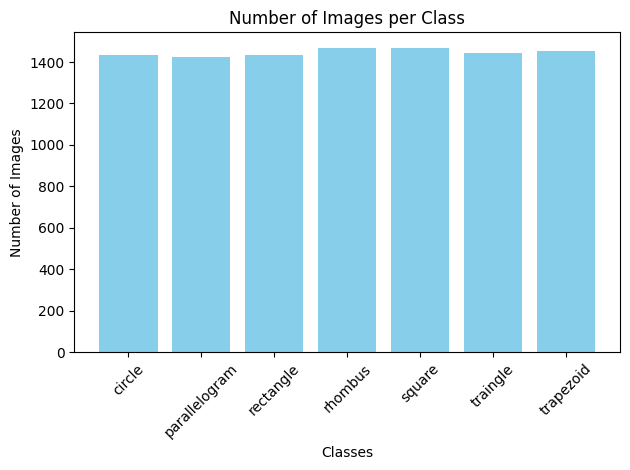


Number of images per class:
circle: 1432 images
parallelogram: 1423 images
rectangle: 1432 images
rhombus: 1470 images
square: 1470 images
traingle: 1446 images
trapezoid: 1455 images


In [12]:
from collections import Counter

# Define the unified class list
class_names_list = [
    'circle', 'parallelogram', 'rectangle',
    'rhombus', 'square', 'traingle', 'trapezoid'
]

# Display the number of images per class (based on labels)
label_folder = "Shapes_Dataset/train/labels"
class_counts = Counter()

for label_file in os.listdir(label_folder):
    with open(os.path.join(label_folder, label_file), 'r') as file:
        for line in file:
            if line.strip():  # Skip empty lines
                class_id = int(line.split()[0])
                class_counts[class_id] += 1

# Plot the bar chart
plt.bar(class_counts.keys(), class_counts.values(), color="skyblue")
plt.title("Number of Images per Class")
plt.xlabel("Classes")
plt.ylabel("Number of Images")
plt.xticks(
    ticks=range(len(class_names_list)),
    labels=class_names_list,
    rotation=45
)
plt.tight_layout()
plt.show()

# Print class-wise image counts
print("\nNumber of images per class:")
for class_id, count in sorted(class_counts.items()):
    print(f"{class_names_list[class_id]}: {count} images")

In [13]:
print("Training Images:", len(glob.glob(f'Shapes_Dataset/train/images/*.jpg')))
print("Validation Images:", len(glob.glob(f'Shapes_Dataset/valid/images/*.jpg')))
print("Test Images:", len(glob.glob(f'Shapes_Dataset/test/images/*.jpg')))

Training Images: 10141
Validation Images: 2521
Test Images: 1260


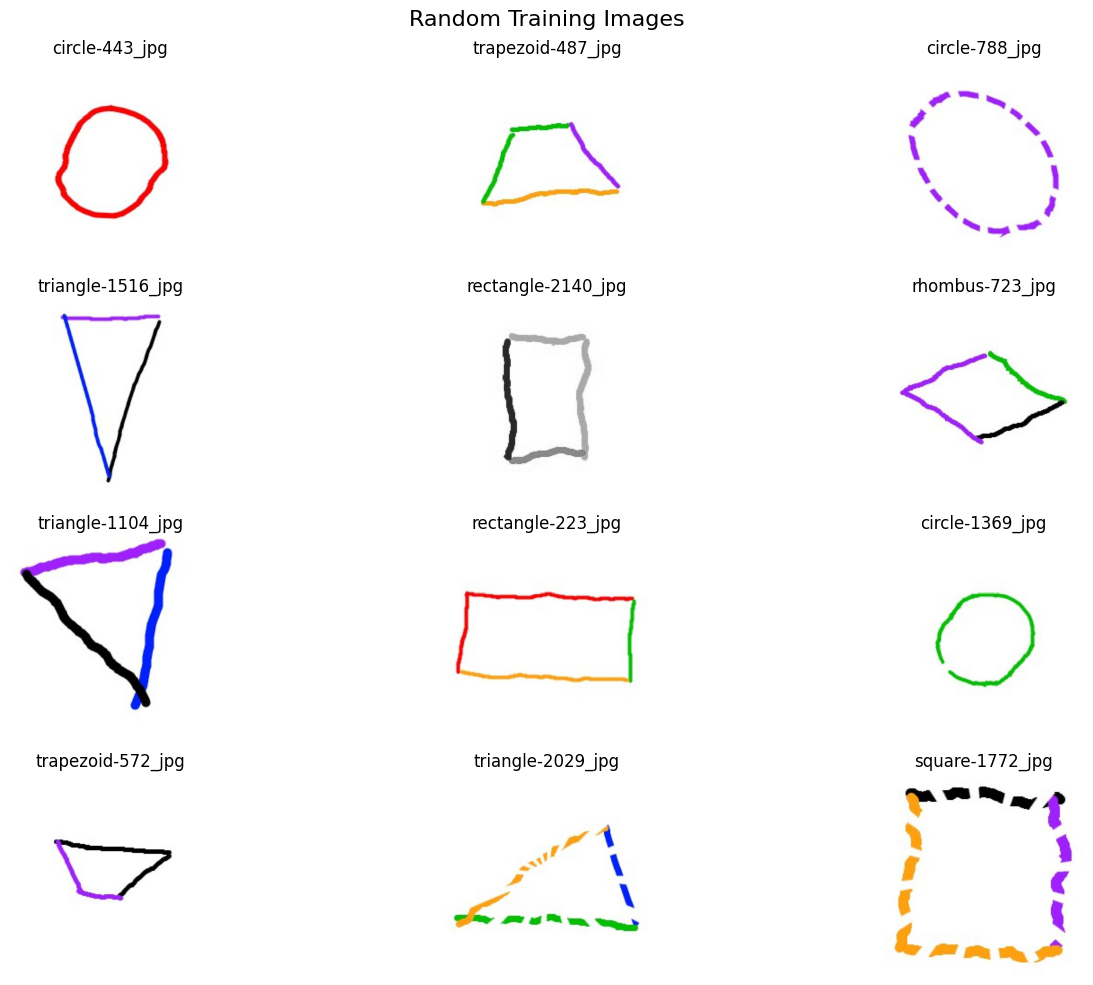

In [14]:
# Display random training images with class labels
train_image_paths = glob.glob(f'Shapes_Dataset/train/images/*.jpg')
random_images = np.random.choice(train_image_paths, 12, replace=False)

plt.figure(figsize=(15, 10))
for i, img_path in enumerate(random_images):
    plt.subplot(4, 3, i + 1)
    plt.imshow(plt.imread(img_path))
    plt.axis("off")
    plt.title(os.path.basename(img_path).split('.')[0])
plt.suptitle("Random Training Images", fontsize=16)
plt.tight_layout()
plt.show()

**Model Initialization and Summary**

In [15]:
model = YOLO("yolov8m.pt")  # Load YOLOv8 medium model
print("Model Summary:")
print(model)

100%|██████████| 49.7M/49.7M [00:00<00:00, 402MB/s]


Model Summary:
YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 48, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(48, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(48, 96, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(96, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True, track_running_stats=True)
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(192, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn): BatchNorm2d(96, eps=0.001, momentum=0.03, affine=True,

**Training**

In [16]:
!yolo task=detect mode=train model=yolov8m.pt data=Shapes_Dataset/data.yaml epochs=20 imgsz=640

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=Shapes_Dataset/data.yaml, degrees=0.0, deterministic=True, device=cuda:0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8m.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=T

**Model Validation and Accuracy**

In [17]:
!yolo task=detect mode=val model=/content/runs/detect/train/weights/best.pt data=Shapes_Dataset/data.yaml

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 910.9±397.5 MB/s, size: 17.3 KB)
val: Scanning /content/Shapes_Dataset/valid/labels.cache... 2521 images, 2 backgrounds, 0 corrupt: 100% 2521/2521 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% 158/158 [00:58<00:00,  2.69it/s]
                   all       2521       2519      0.999          1      0.995      0.992
                circle        360        360      0.997          1      0.995      0.987
         parallelogram        360        360      0.999          1      0.995      0.994
             rectangle        359        359      0.997          1      0.995      0.982
               rhombus        360        360          1          1      0.995      0.995
                square        360        360    

In [18]:
from ultralytics import YOLO

model = YOLO("runs/detect/train/weights/best.pt")  # Load the best trained model
results = model.val(data="/content/Shapes_Dataset/data.yaml")  # Validate the model

print(f"Model Accuracy (mAP50): {results.box.map50 * 100:.2f}%")

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 707.4±185.2 MB/s, size: 17.3 KB)


val: Scanning /content/Shapes_Dataset/valid/labels.cache... 2521 images, 2 backgrounds, 0 corrupt: 100%|██████████| 2521/2521 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 158/158 [01:00<00:00,  2.62it/s]


                   all       2521       2519      0.999          1      0.995      0.992
                circle        360        360      0.997          1      0.995      0.987
         parallelogram        360        360      0.999          1      0.995      0.994
             rectangle        359        359      0.997          1      0.995      0.982
               rhombus        360        360          1          1      0.995      0.995
                square        360        360          1          1      0.995      0.995
              traingle        360        360      0.997          1      0.995      0.995
             trapezoid        360        360          1      0.997      0.995      0.995
Speed: 0.3ms preprocess, 20.2ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val2
Model Accuracy (mAP50): 99.49%


**Visualizing Training Progress**

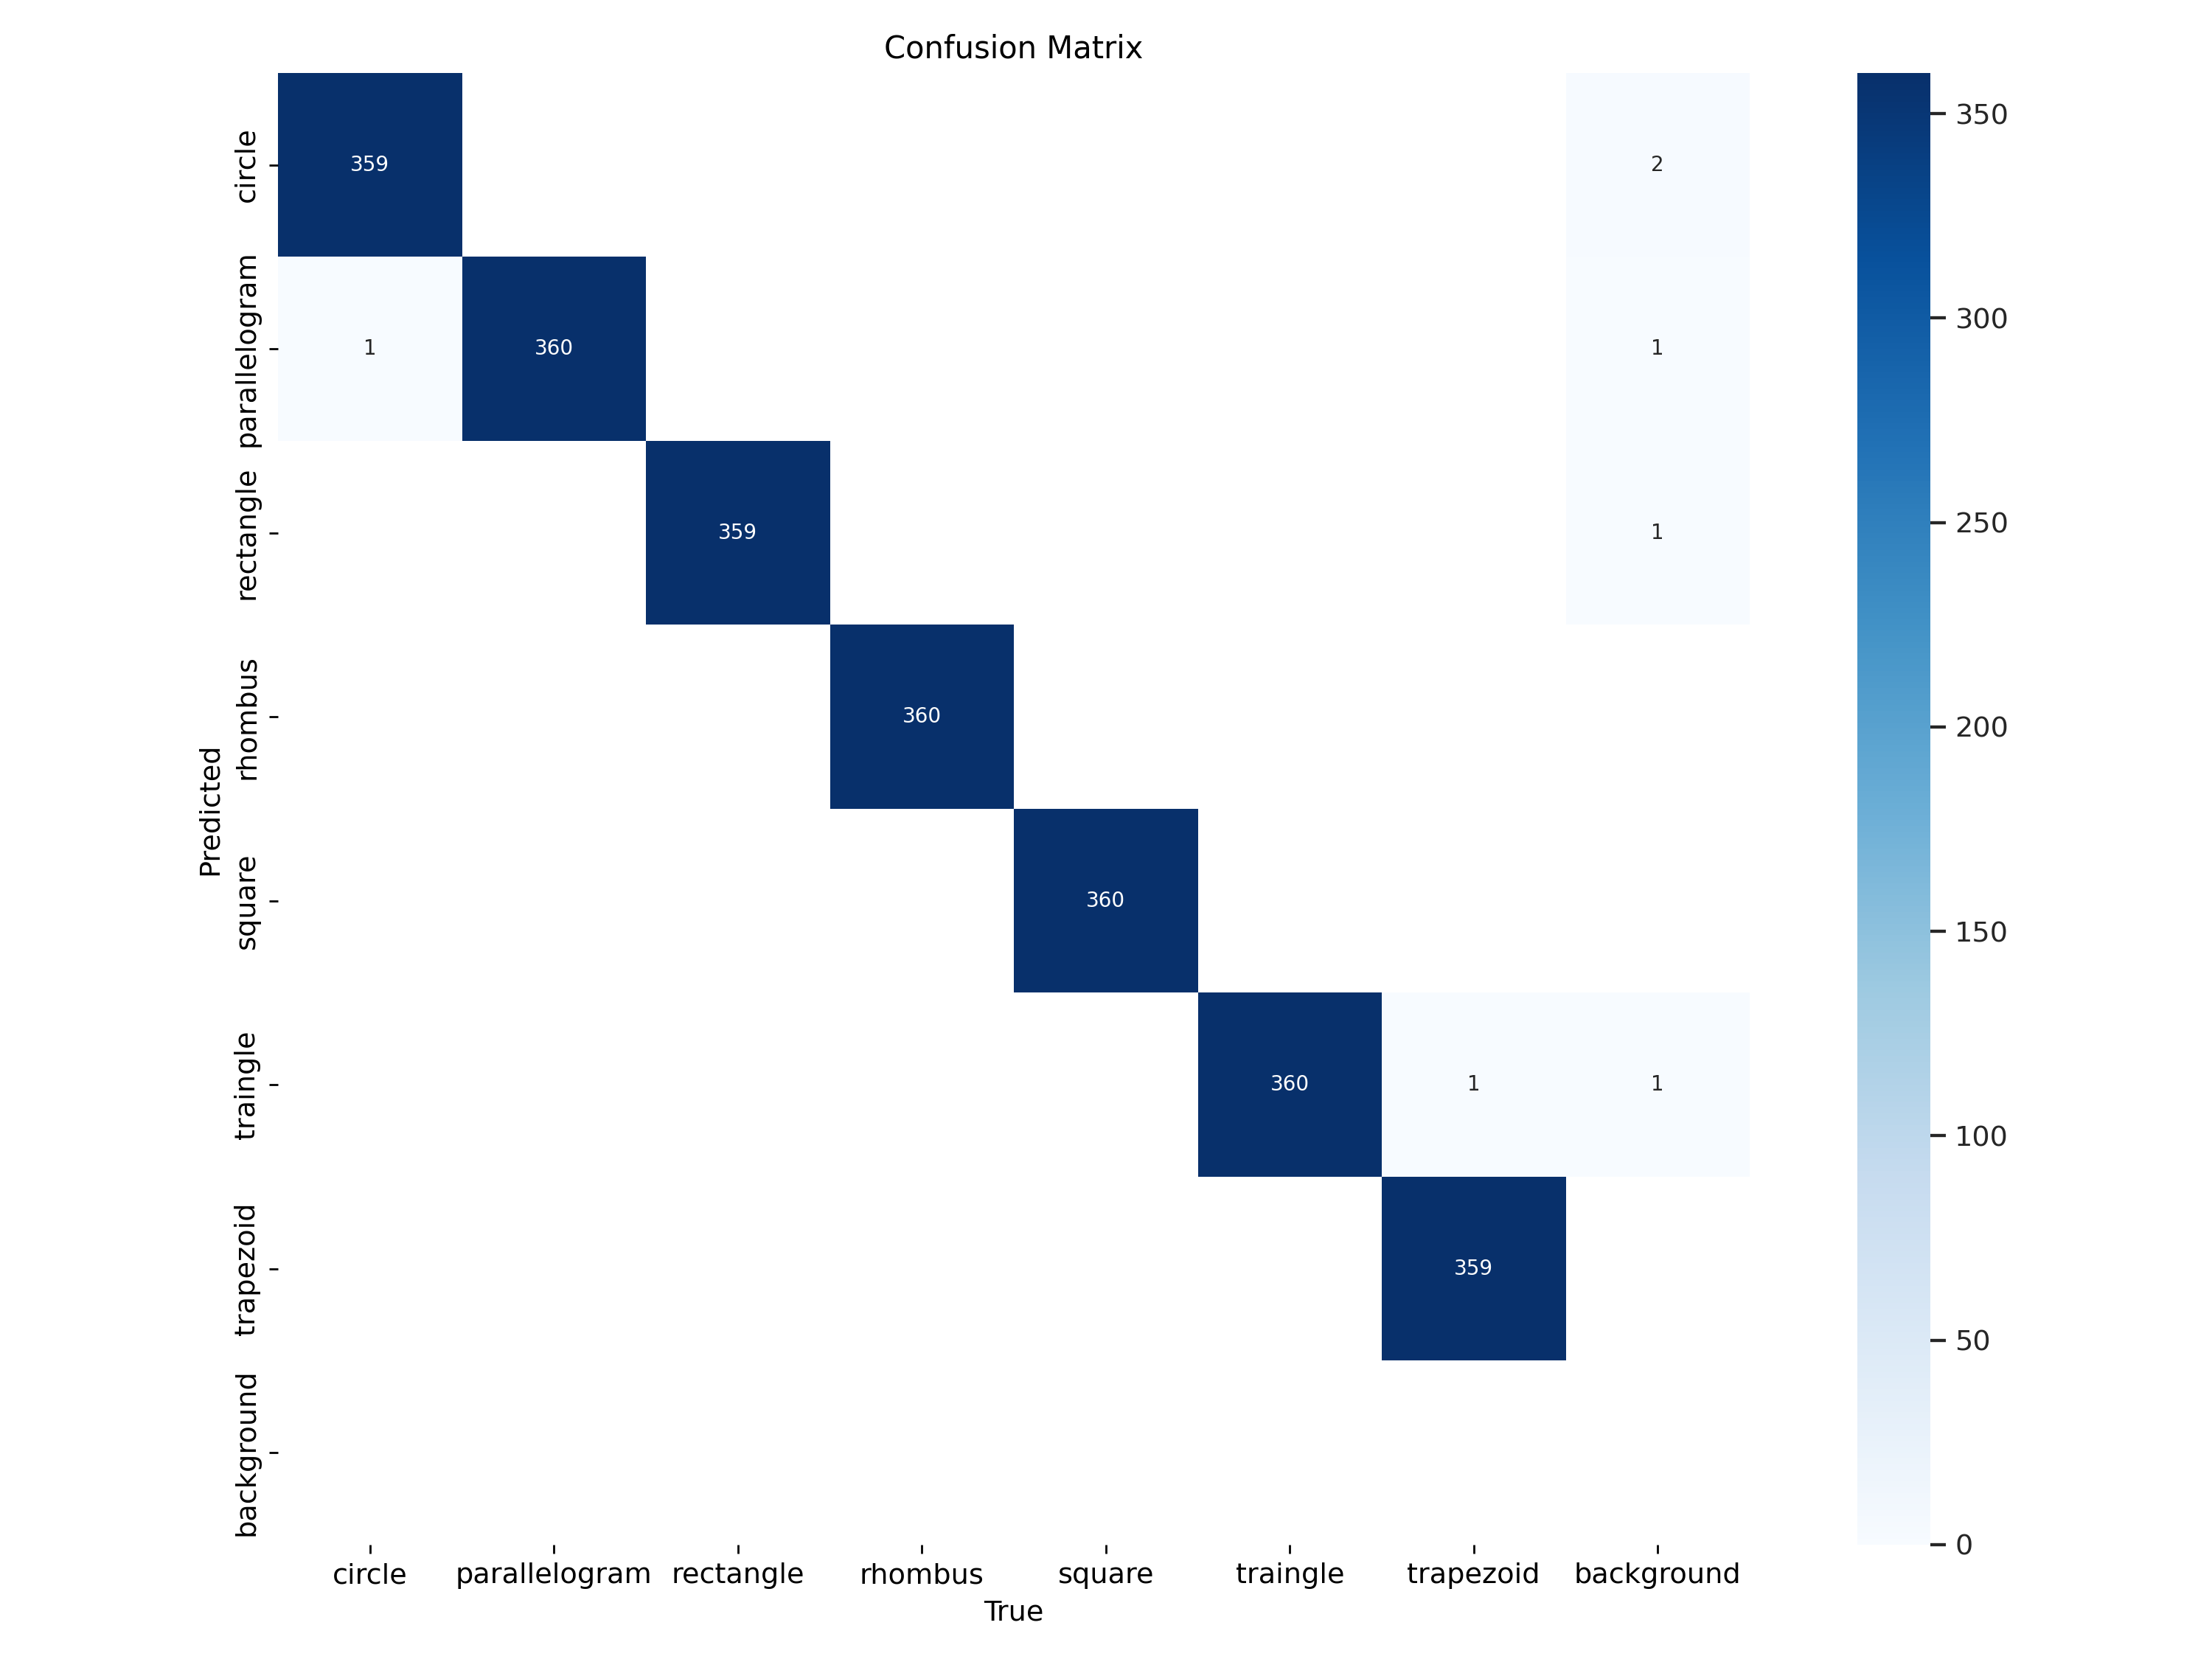

In [19]:
train_results_path = "/content/runs/detect/train/"

# Confusion Matrix
confusion_matrix_image = train_results_path + "confusion_matrix.png"
display(Image(filename=confusion_matrix_image, width=600))

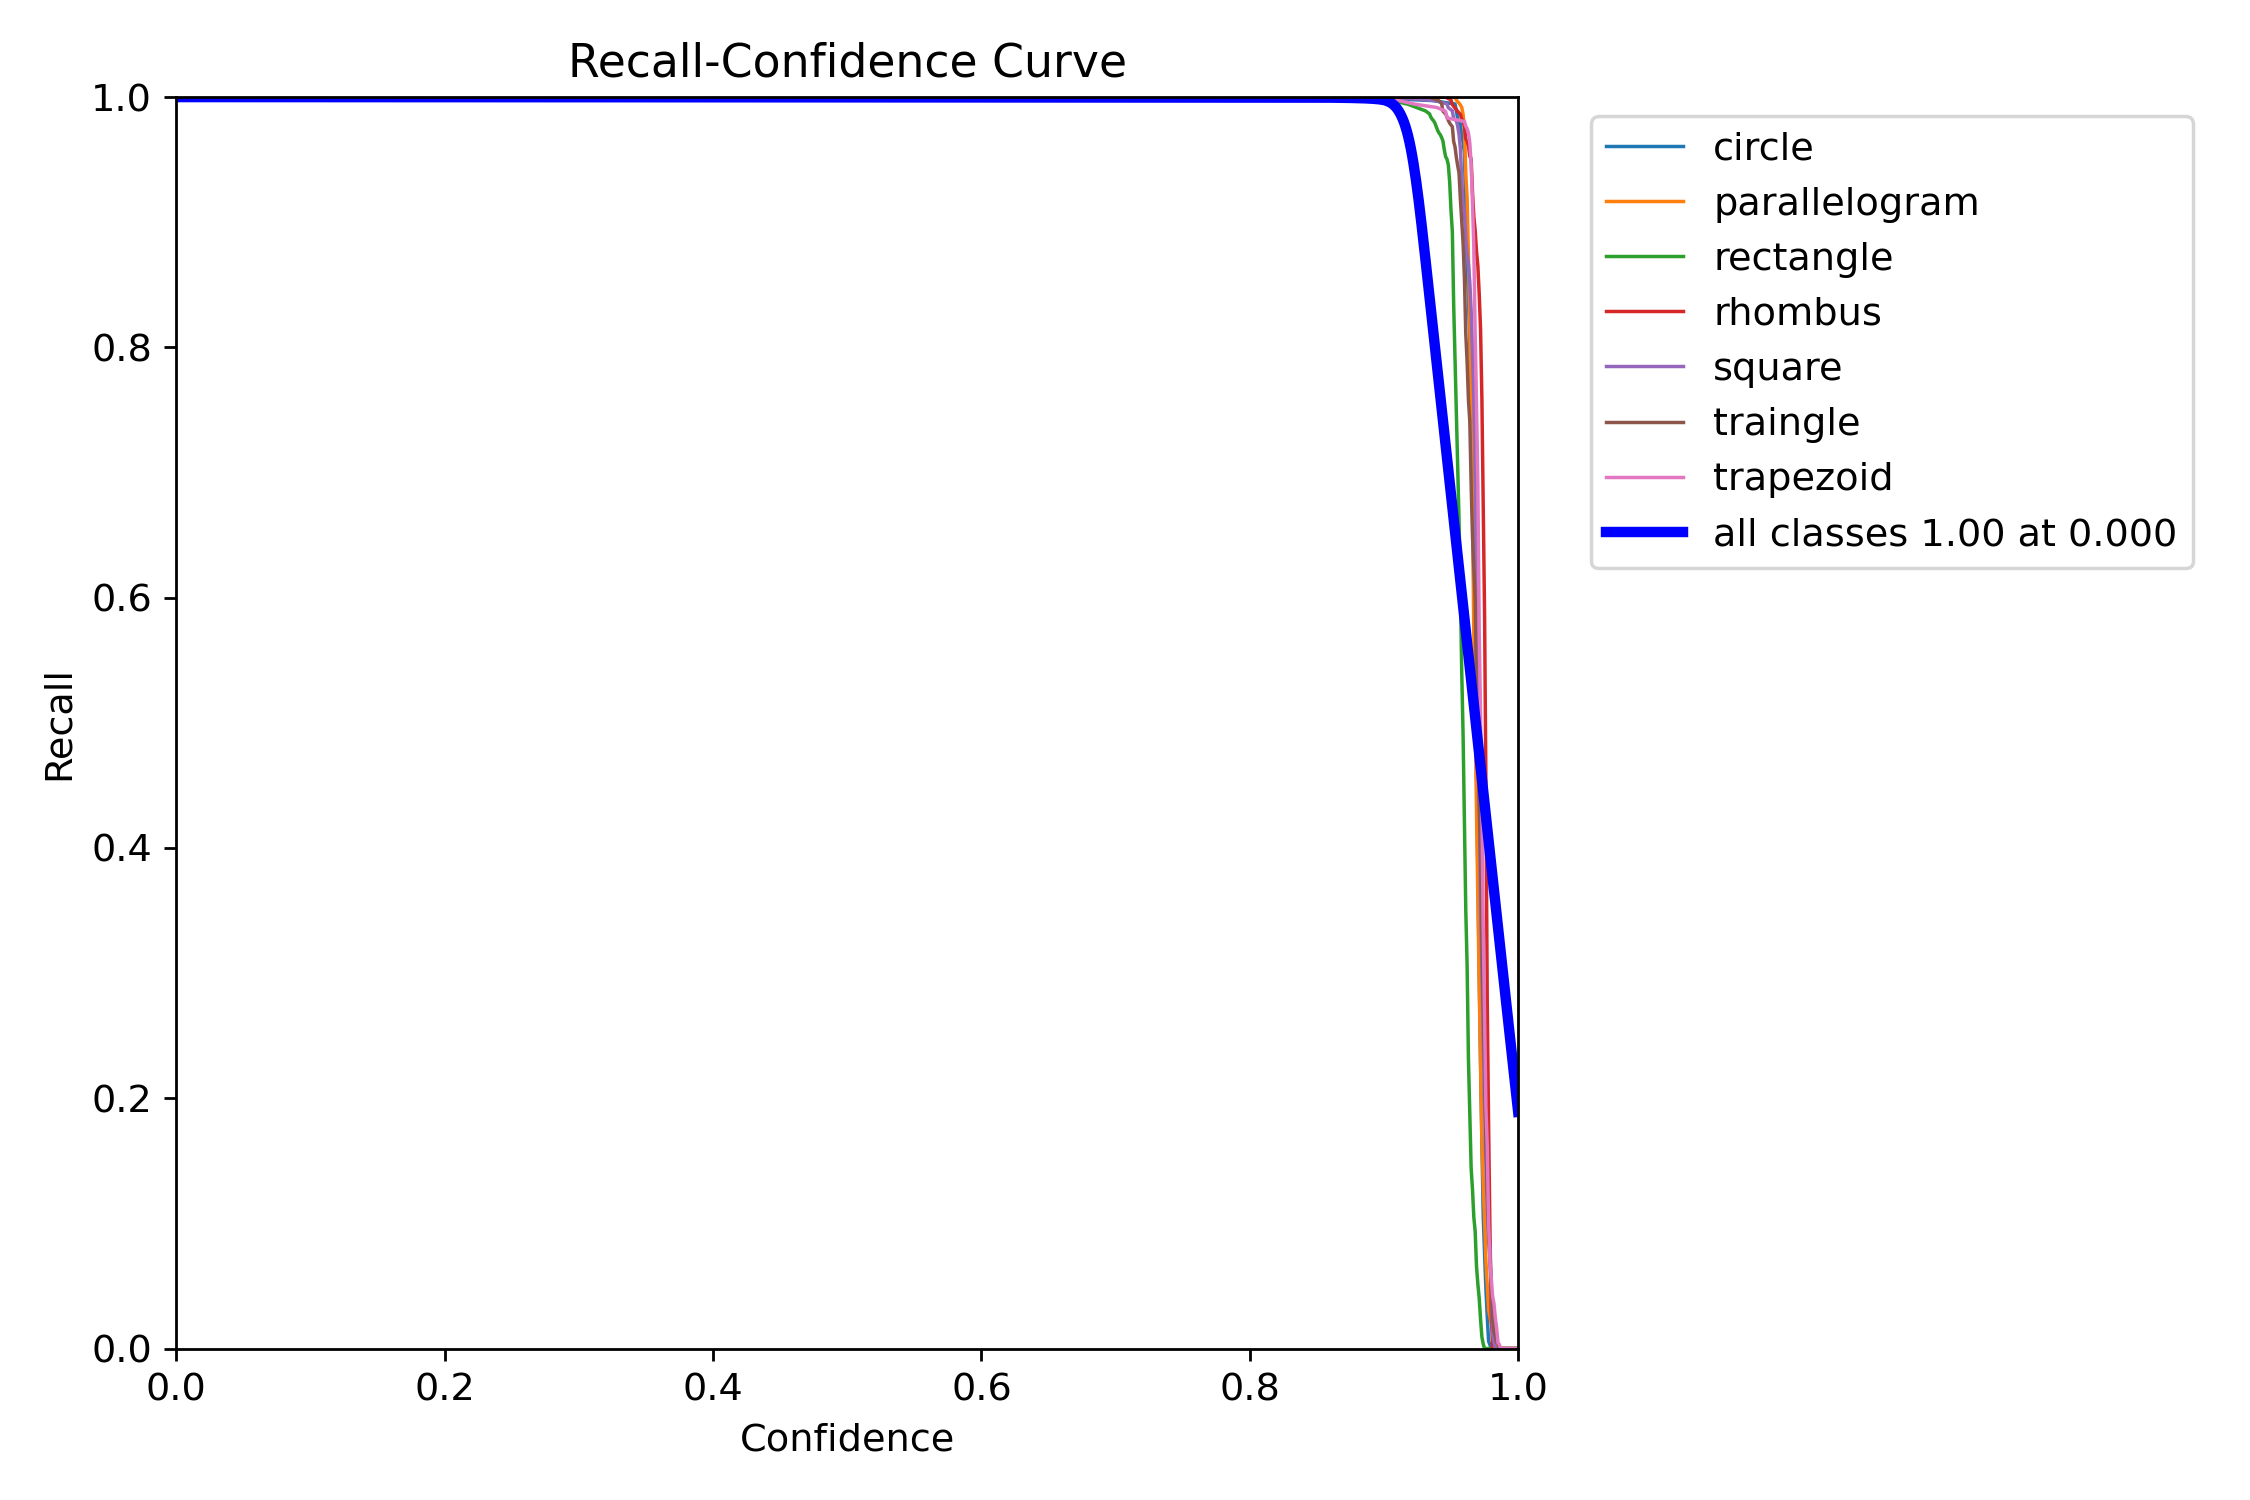

In [20]:
# Recall-Confidence Curve
R_curve_image = train_results_path + "R_curve.png"
display(Image(filename=R_curve_image, width=600))

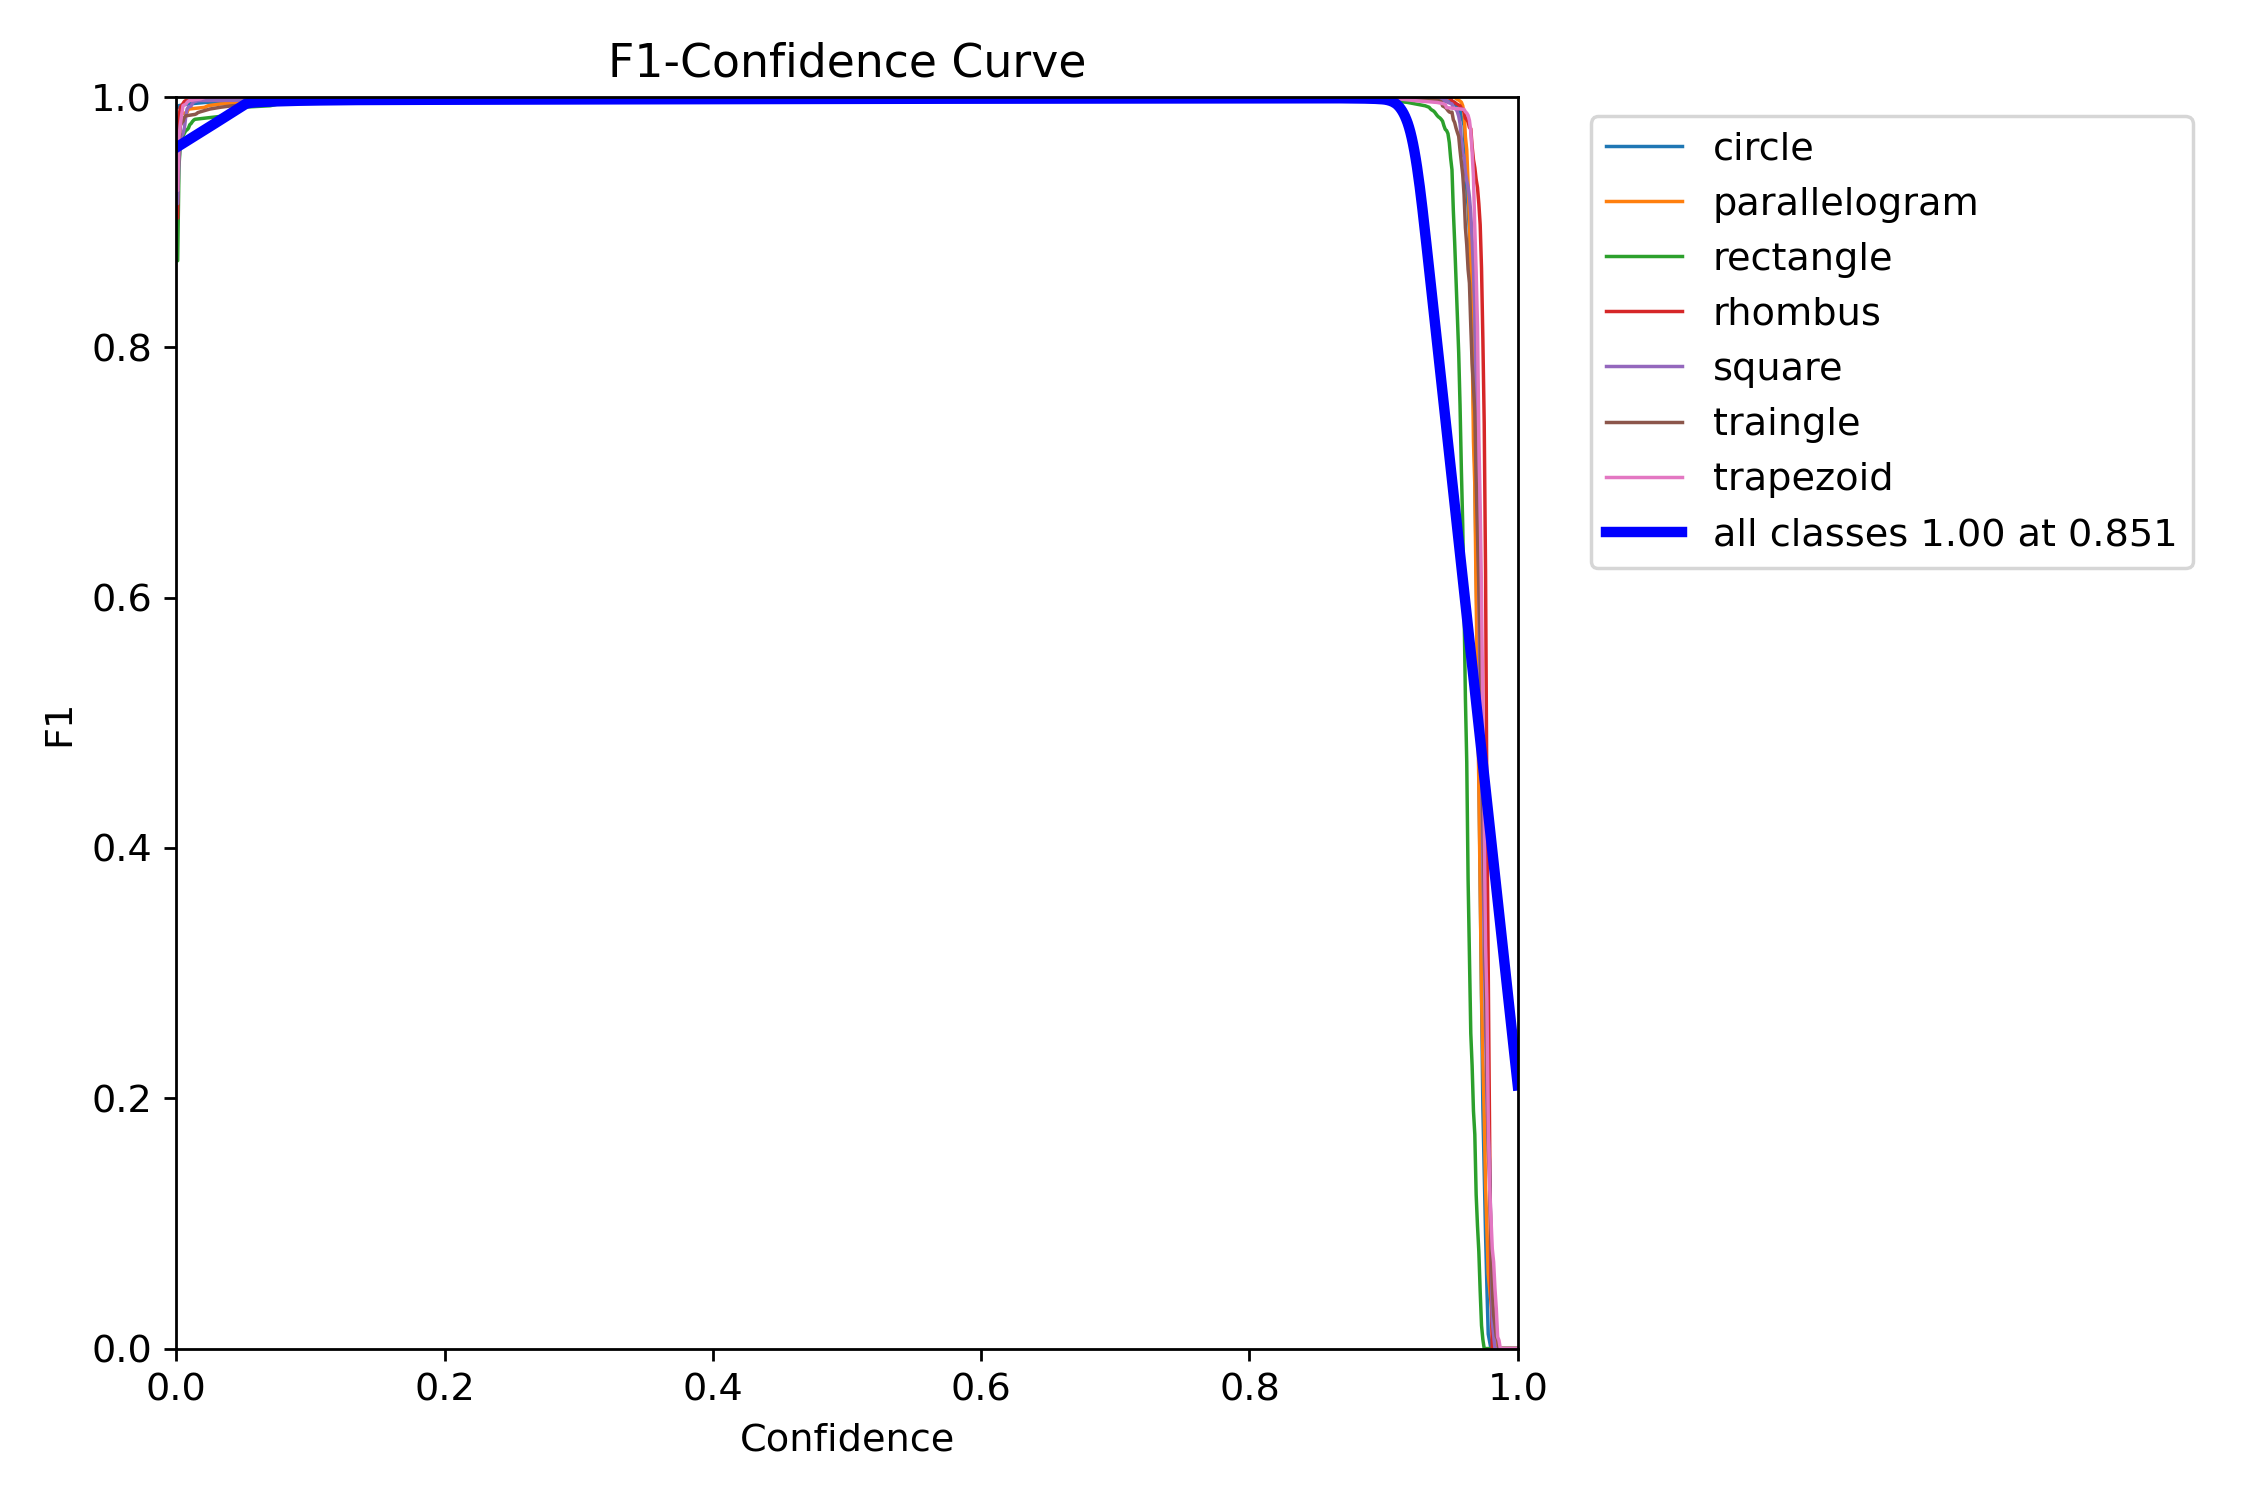

In [21]:
# F1-Confidence Curve
F1_curve_image = train_results_path + "F1_curve.png"
display(Image(filename=F1_curve_image, width=600))

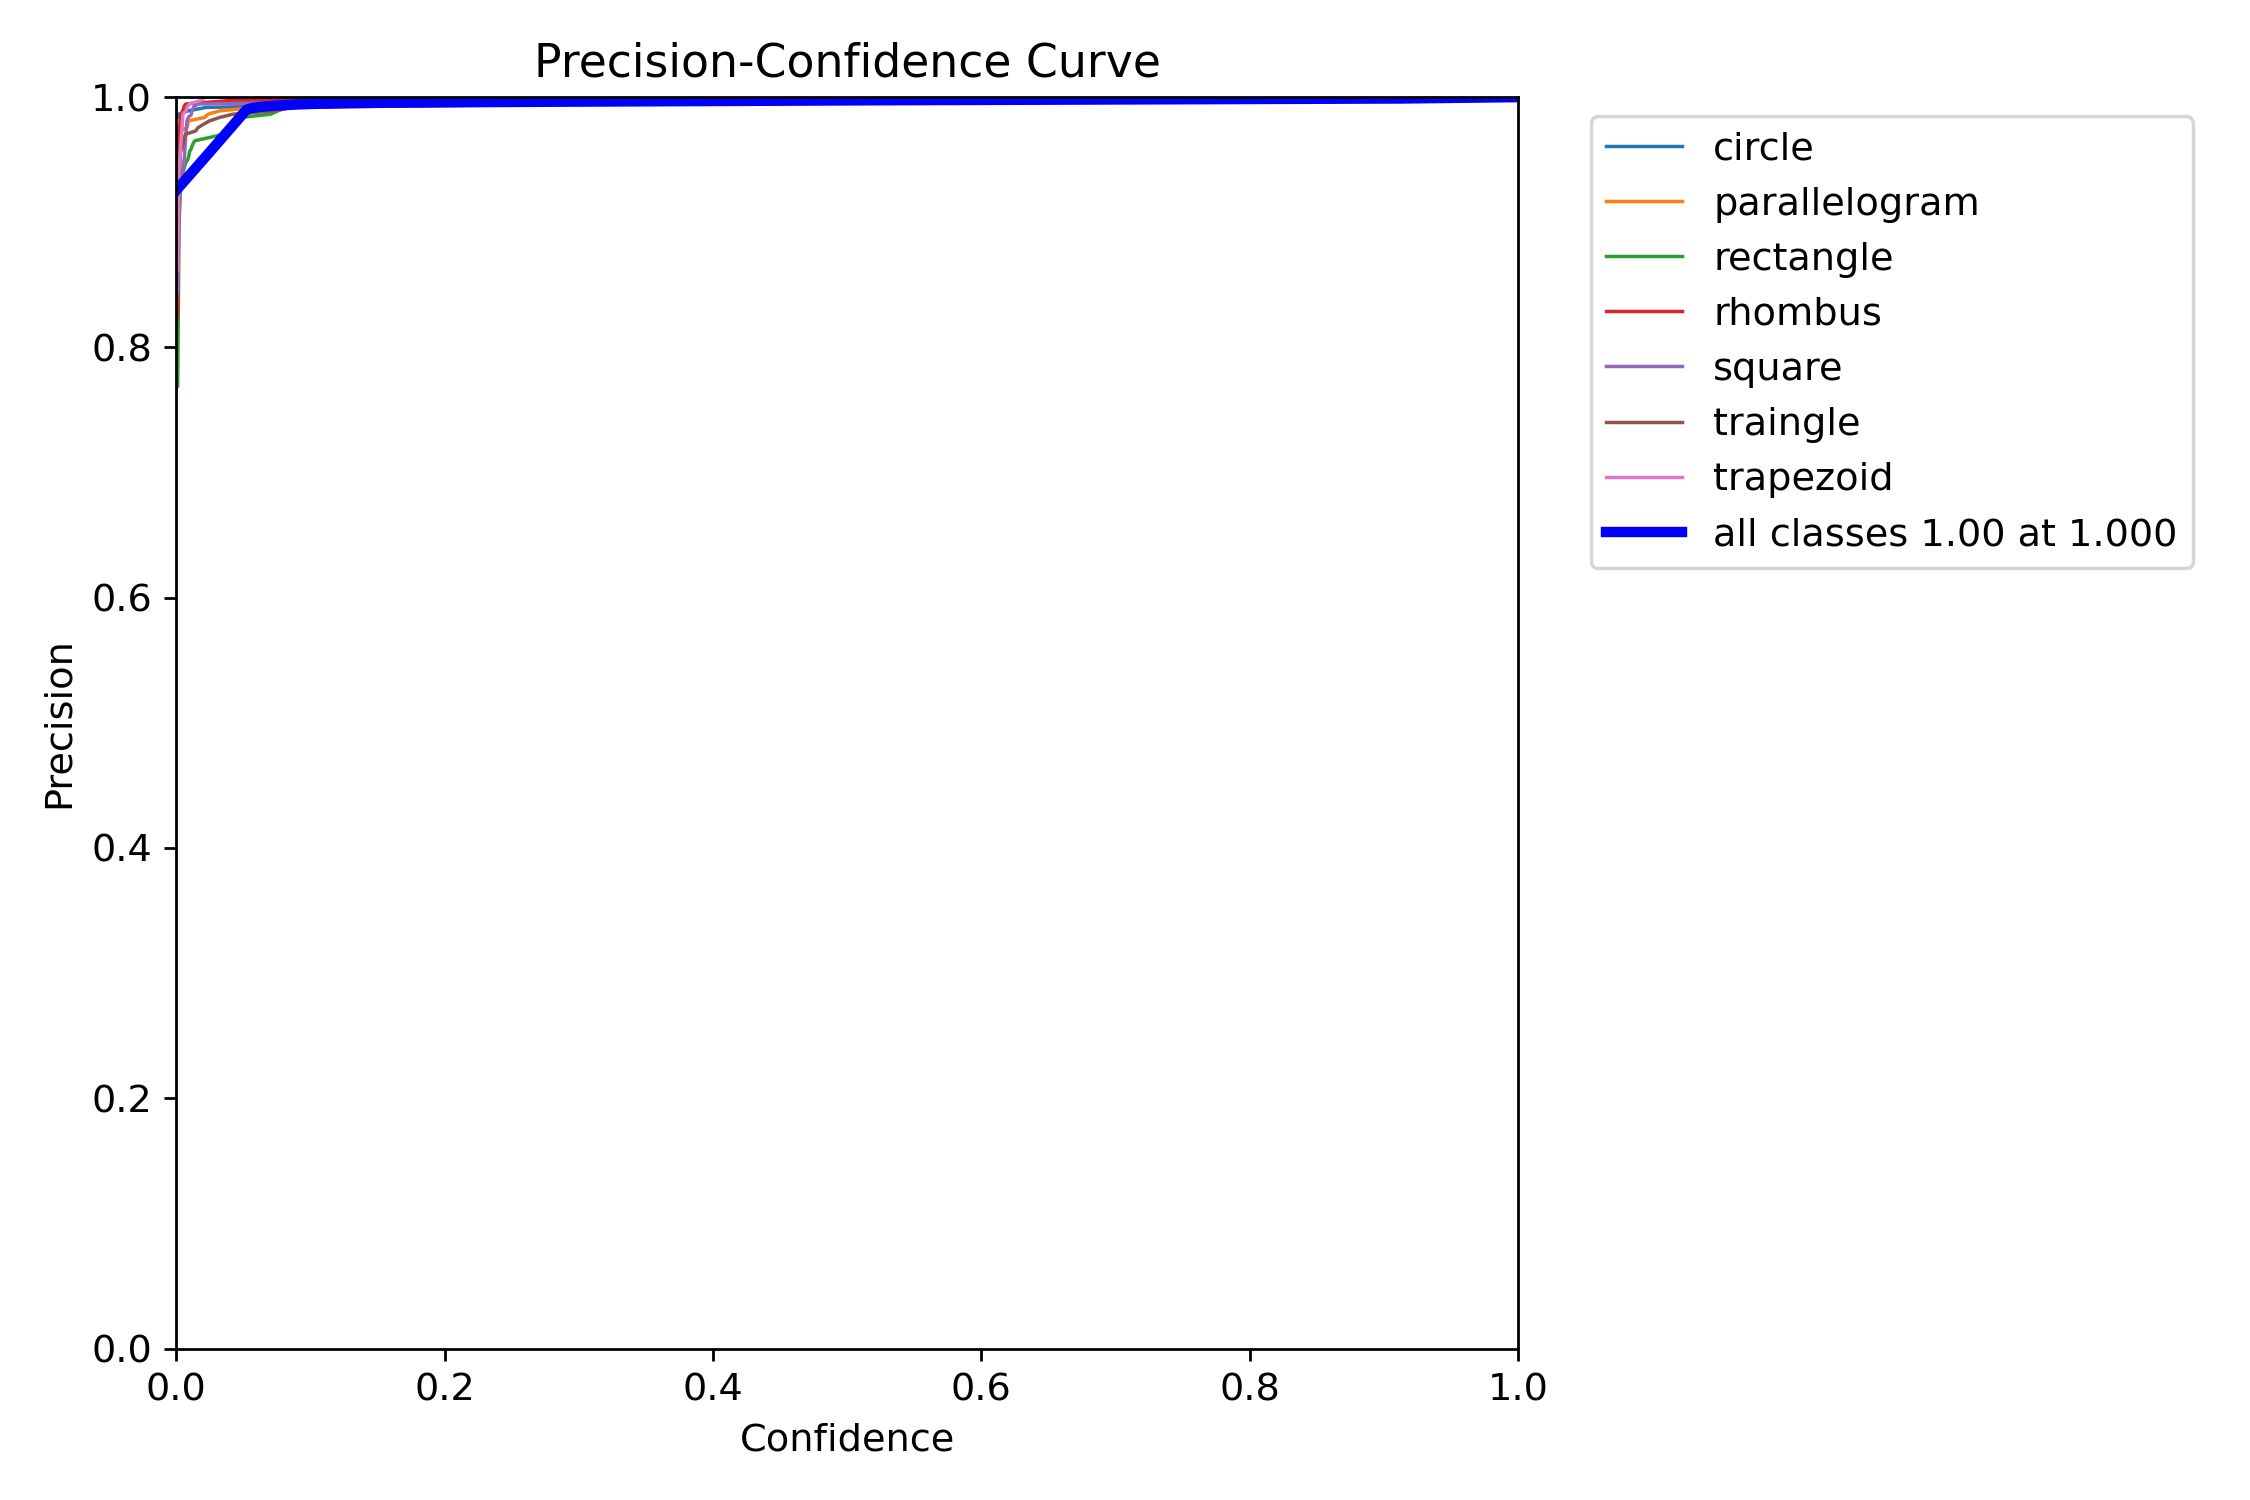

In [22]:
# Precision-Confidence Curve
P_curve_image = train_results_path + "P_curve.png"
display(Image(filename=P_curve_image, width=600))

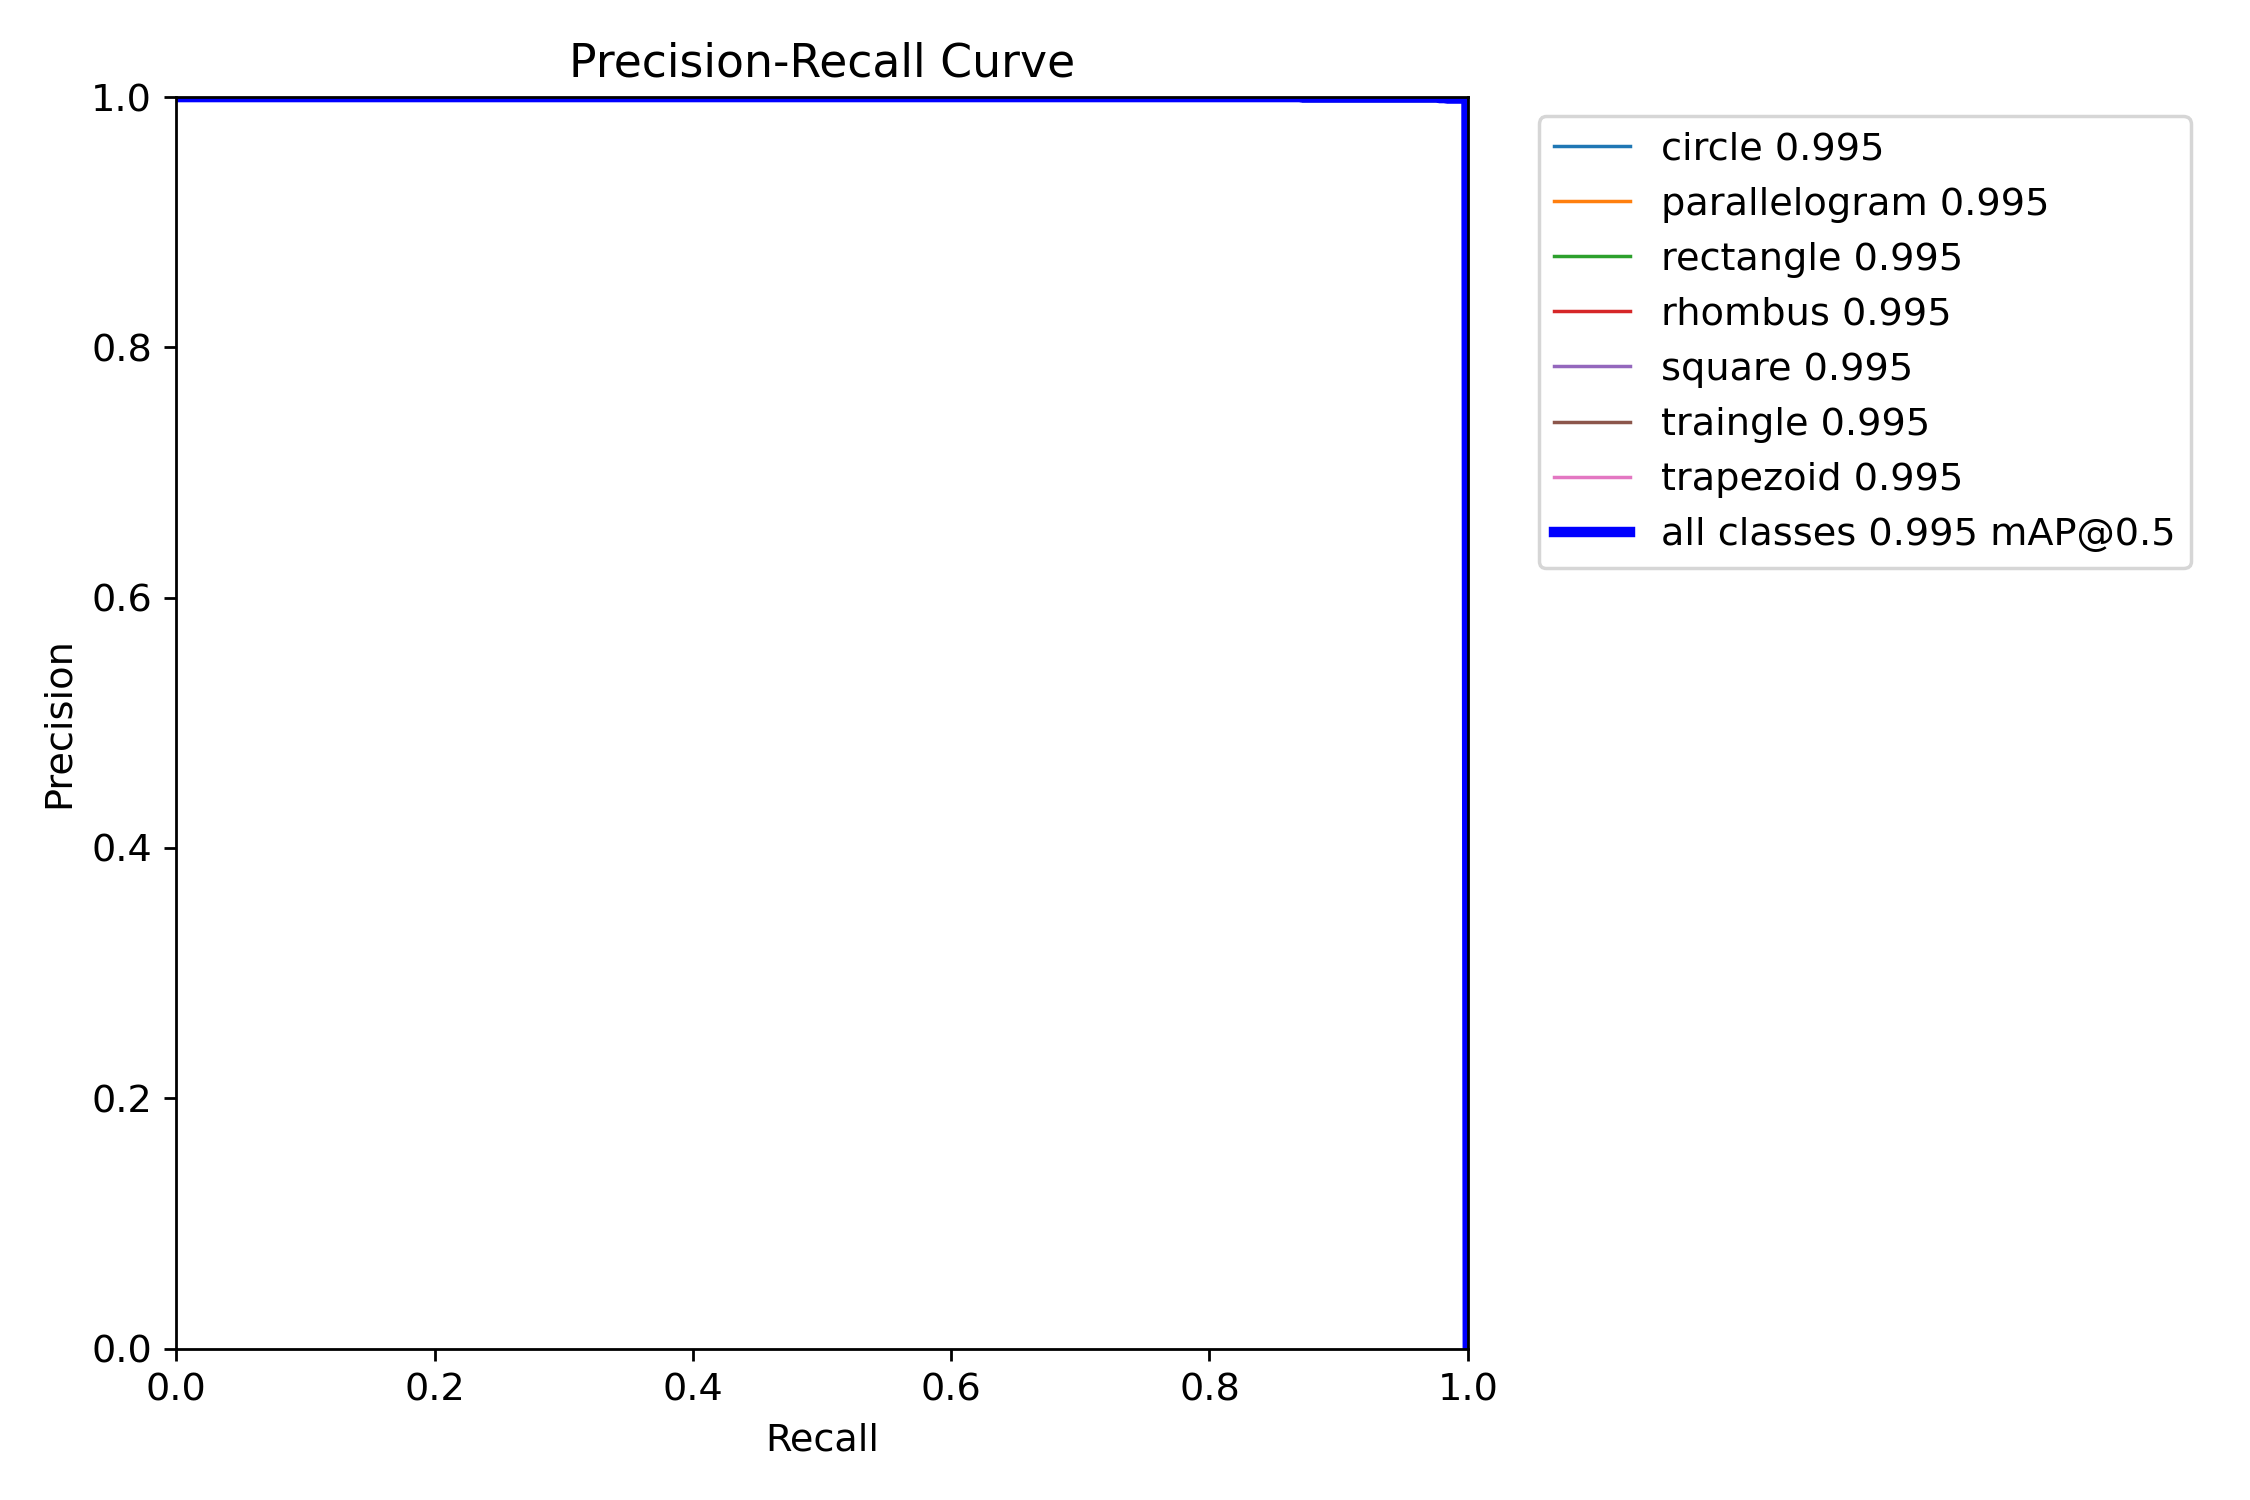

In [23]:
# Precision-Recall Curve
PR_curve_image = train_results_path + "PR_curve.png"
display(Image(filename=PR_curve_image, width=600))

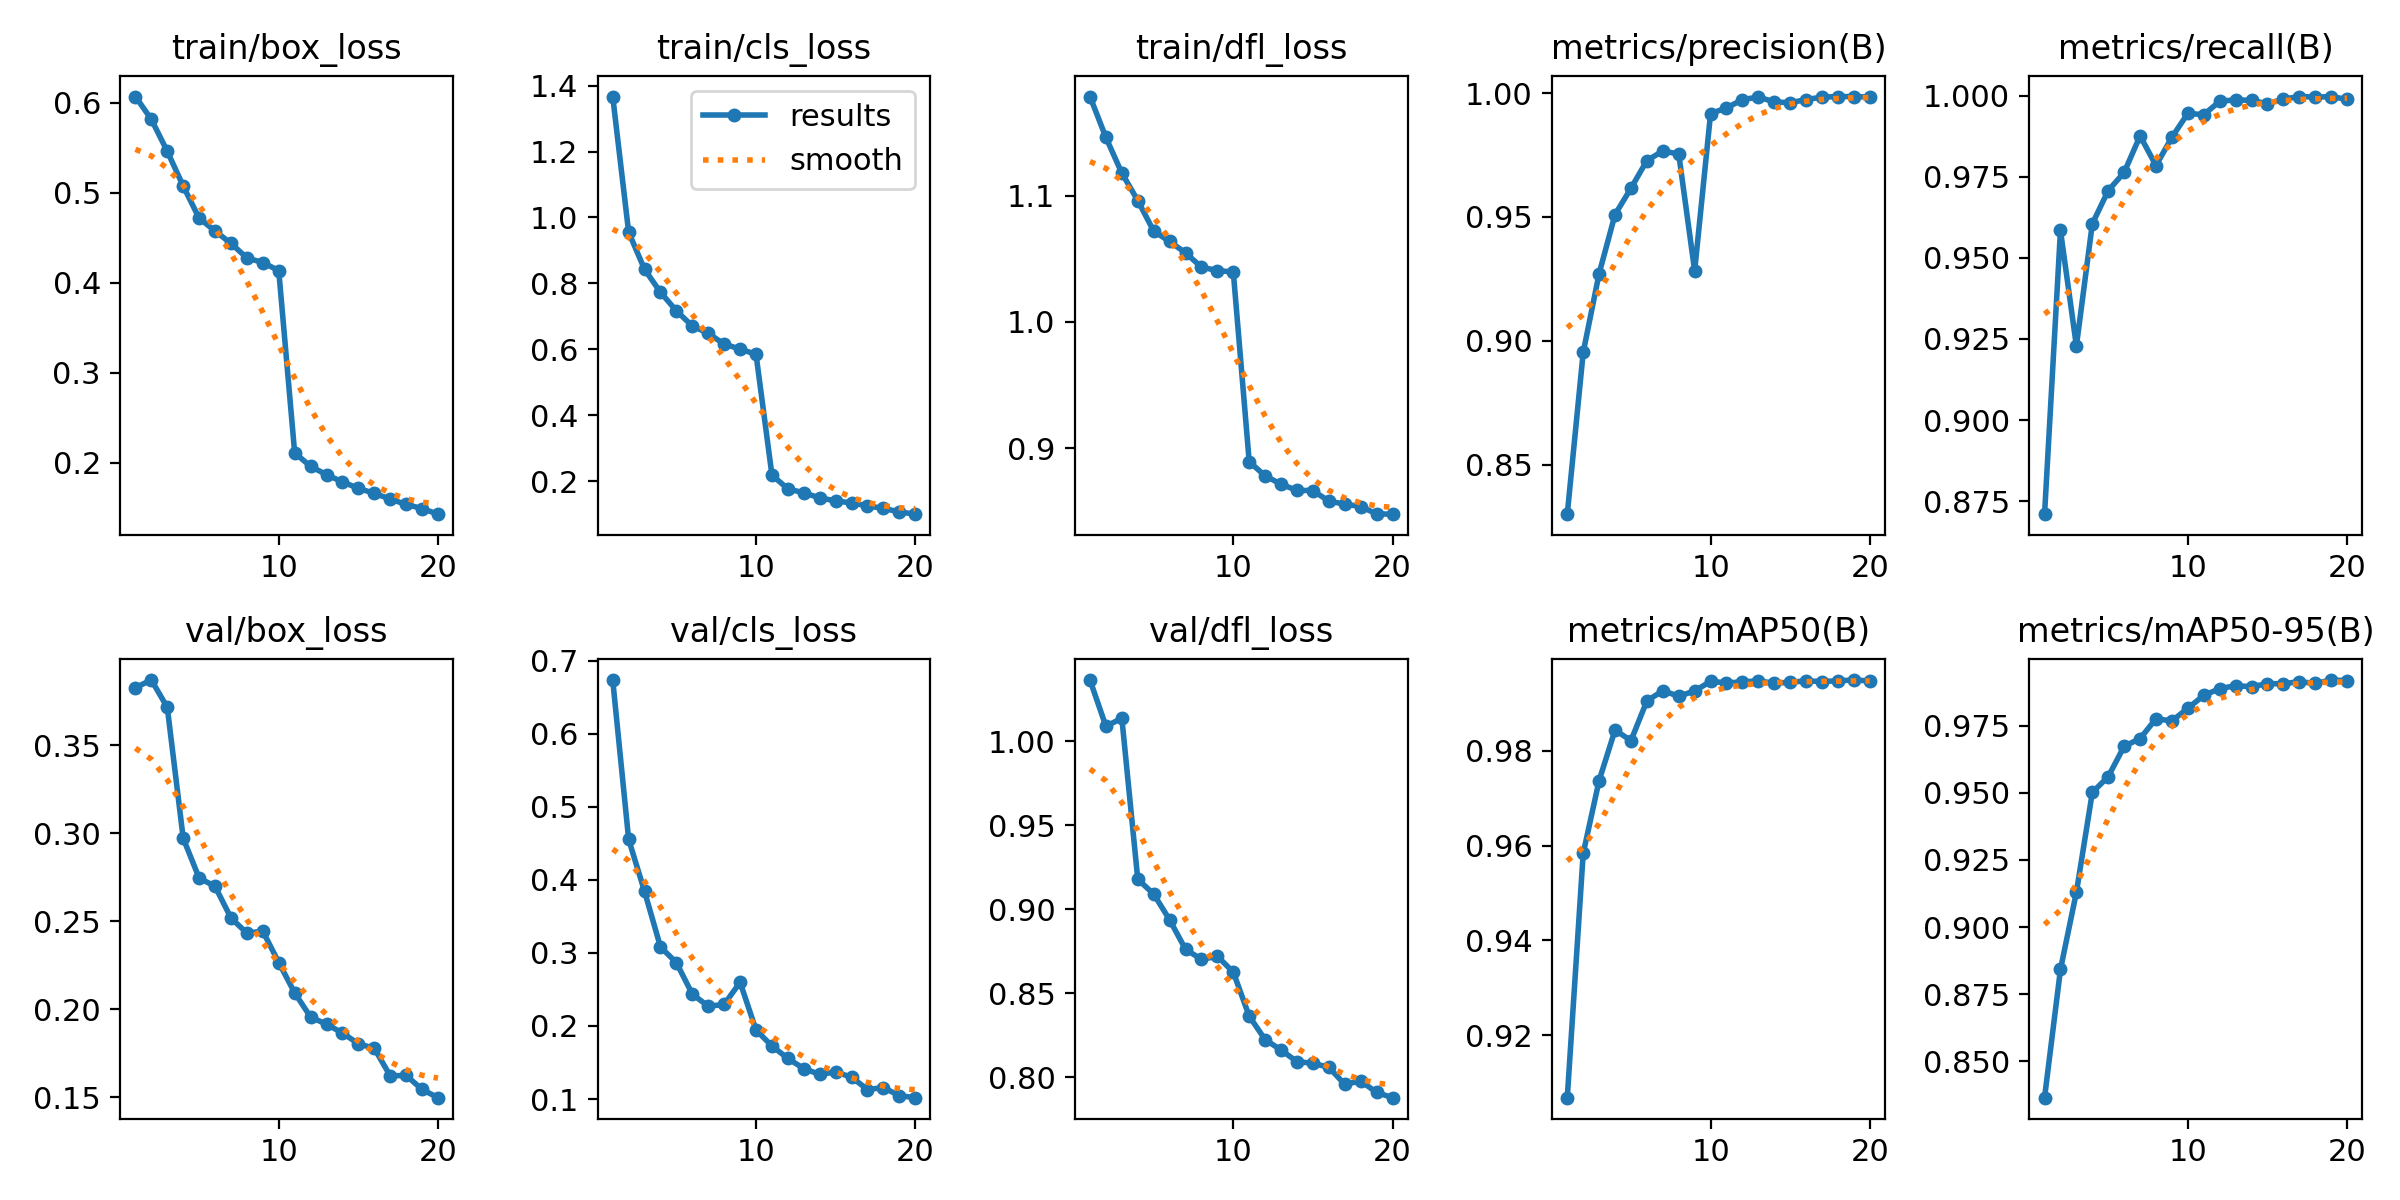

In [24]:
# overall results
results_image = train_results_path + "results.png"
display(Image(filename=results_image, width=600))

**Testing and Predictions Visualization**

In [25]:
!yolo task=detect mode=predict model=/content/runs/detect/train/weights/best.pt conf=0.5 source=Shapes_Dataset/test/images save=True

Ultralytics 8.3.126 🚀 Python-3.11.12 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 92 layers, 25,843,813 parameters, 0 gradients, 78.7 GFLOPs

image 1/1260 /content/Shapes_Dataset/test/images/circle-1032_jpg.rf.2ddb76cf25be164bd19d2e83811278b8.jpg: 640x640 1 circle, 37.0ms
image 2/1260 /content/Shapes_Dataset/test/images/circle-104_jpg.rf.9a9b43cbcb2630d9fc74a7d2b9e7ac11.jpg: 640x640 1 circle, 37.1ms
image 3/1260 /content/Shapes_Dataset/test/images/circle-1052_jpg.rf.2366964b884417a34c2c776db93d9871.jpg: 640x640 1 circle, 37.0ms
image 4/1260 /content/Shapes_Dataset/test/images/circle-1056_jpg.rf.b008c1b617caf1318e3ccec63da95aba.jpg: 640x640 1 circle, 36.4ms
image 5/1260 /content/Shapes_Dataset/test/images/circle-1063_jpg.rf.eaf5610a7ab62c7d3acf43d375707959.jpg: 640x640 1 circle, 36.2ms
image 6/1260 /content/Shapes_Dataset/test/images/circle-1069_jpg.rf.48818b4870b40929dc81586a473ae001.jpg: 640x640 1 circle, 36.2ms
image 7/1260 /content/Shapes_Dataset/test/images/

**Model Evaluation**

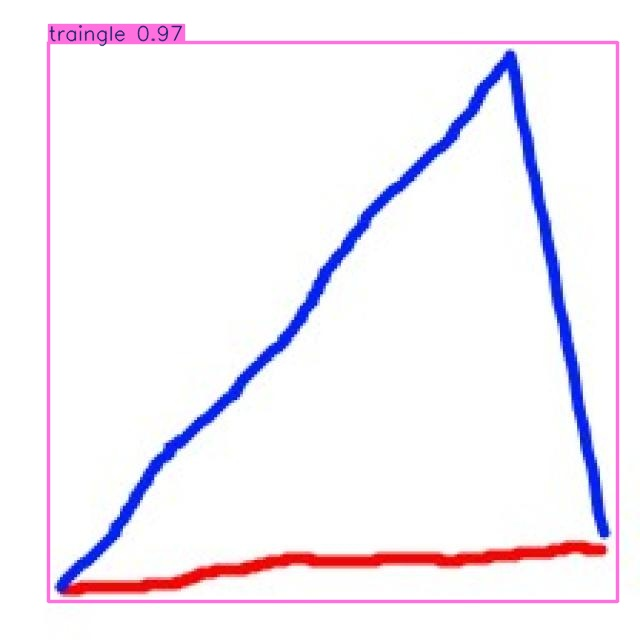

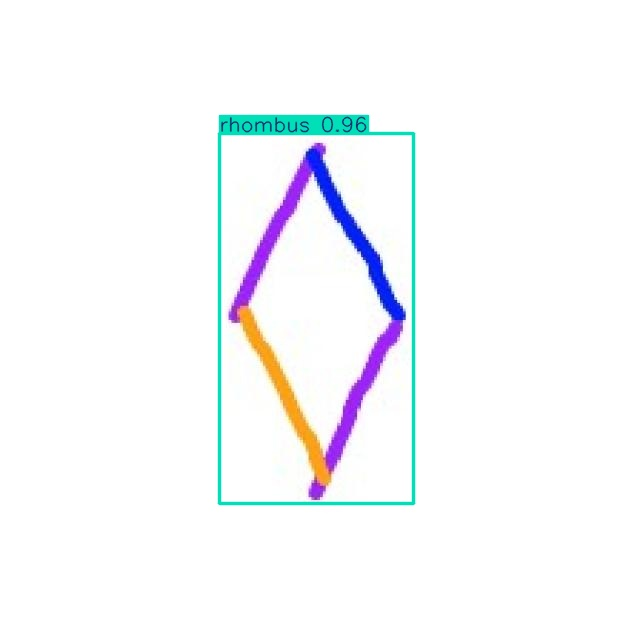

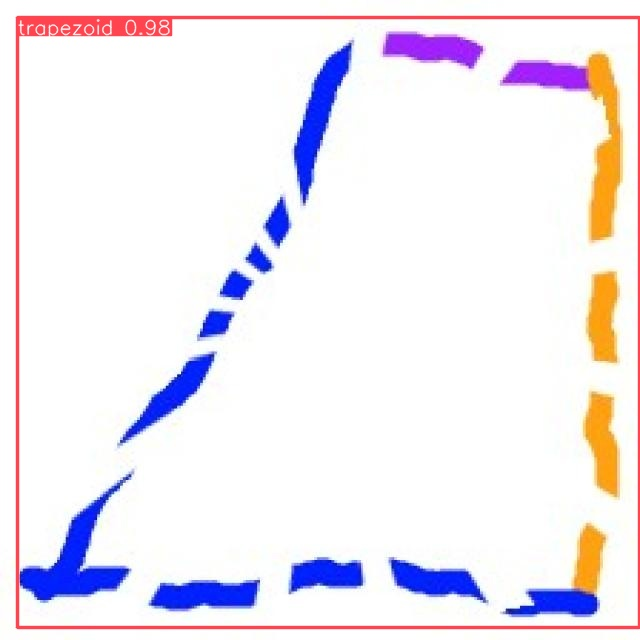

In [27]:
import glob
from IPython.display import Image, display

for image_path in glob.glob(f'/content/runs/detect/predict/*.jpg')[:3]:
      display(Image(filename=image_path, width=600))
      print("\n")

**Performance Metrics Visualization**

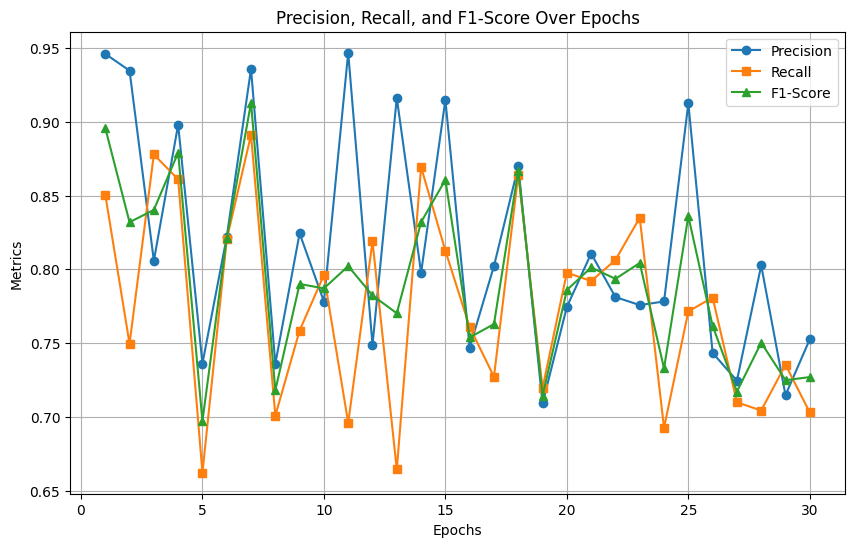

In [28]:
# Precision, Recall, and F1-Score
precision = []  # Placeholder for precision values per epoch
recall = []  # Placeholder for recall values per epoch
f1_score = []  # Placeholder for F1-score values per epoch

# Populate with your data (example values for demonstration)
for epoch in range(1, 31):
    precision.append(np.random.uniform(0.7, 0.95))  # Replace with actual metrics
    recall.append(np.random.uniform(0.65, 0.9))  # Replace with actual metrics
    f1_score.append(2 * (precision[-1] * recall[-1]) / (precision[-1] + recall[-1]))

plt.figure(figsize=(10, 6))
plt.plot(range(1, 31), precision, label="Precision", marker="o")
plt.plot(range(1, 31), recall, label="Recall", marker="s")
plt.plot(range(1, 31), f1_score, label="F1-Score", marker="^")
plt.xlabel("Epochs")
plt.ylabel("Metrics")
plt.title("Precision, Recall, and F1-Score Over Epochs")
plt.legend()
plt.grid(True)
plt.show()

**Save the Model**

In [29]:
!cp /content/runs/detect/train/weights/best.pt /content/yolov8_shapes_detection_model.pt
print("✅ Model saved as yolov8_shapes_detection_model.pt")

✅ Model saved as yolov8_shapes_detection_model.pt


**Test Image Evaluation**

In [30]:
def predict_image(image_path):
    """
    Load the trained model and make predictions on a given image.
    Shows detected class and confidence score.
    """
    model = YOLO("/content/yolov8_shapes_detection_model.pt")  # Load trained model
    results = model(image_path)  # Run inference

    for result in results:
        for box in result.boxes:
            class_id = result.names[int(box.cls[0])]
            confidence = box.conf[0].item() * 100  # Convert to percentage
            print(f"Detected: {class_id} | Confidence: {confidence:.2f}%")

    # Display image with detections
    display(Image(filename=image_path, width=600))

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



image 1/1 /content/drive/My Drive/Shapes/triangle.png: 640x576 1 traingle, 45.2ms
Speed: 2.7ms preprocess, 45.2ms inference, 1.7ms postprocess per image at shape (1, 3, 640, 576)
Detected: traingle | Confidence: 96.99%


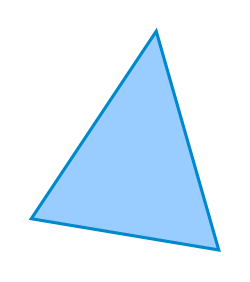

In [40]:
test_image_path = "/content/drive/My Drive/Shapes/triangle.png"
predict_image(test_image_path)


image 1/1 /content/drive/My Drive/Shapes/circle.png: 640x640 1 circle, 37.2ms
Speed: 4.6ms preprocess, 37.2ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Detected: circle | Confidence: 98.79%


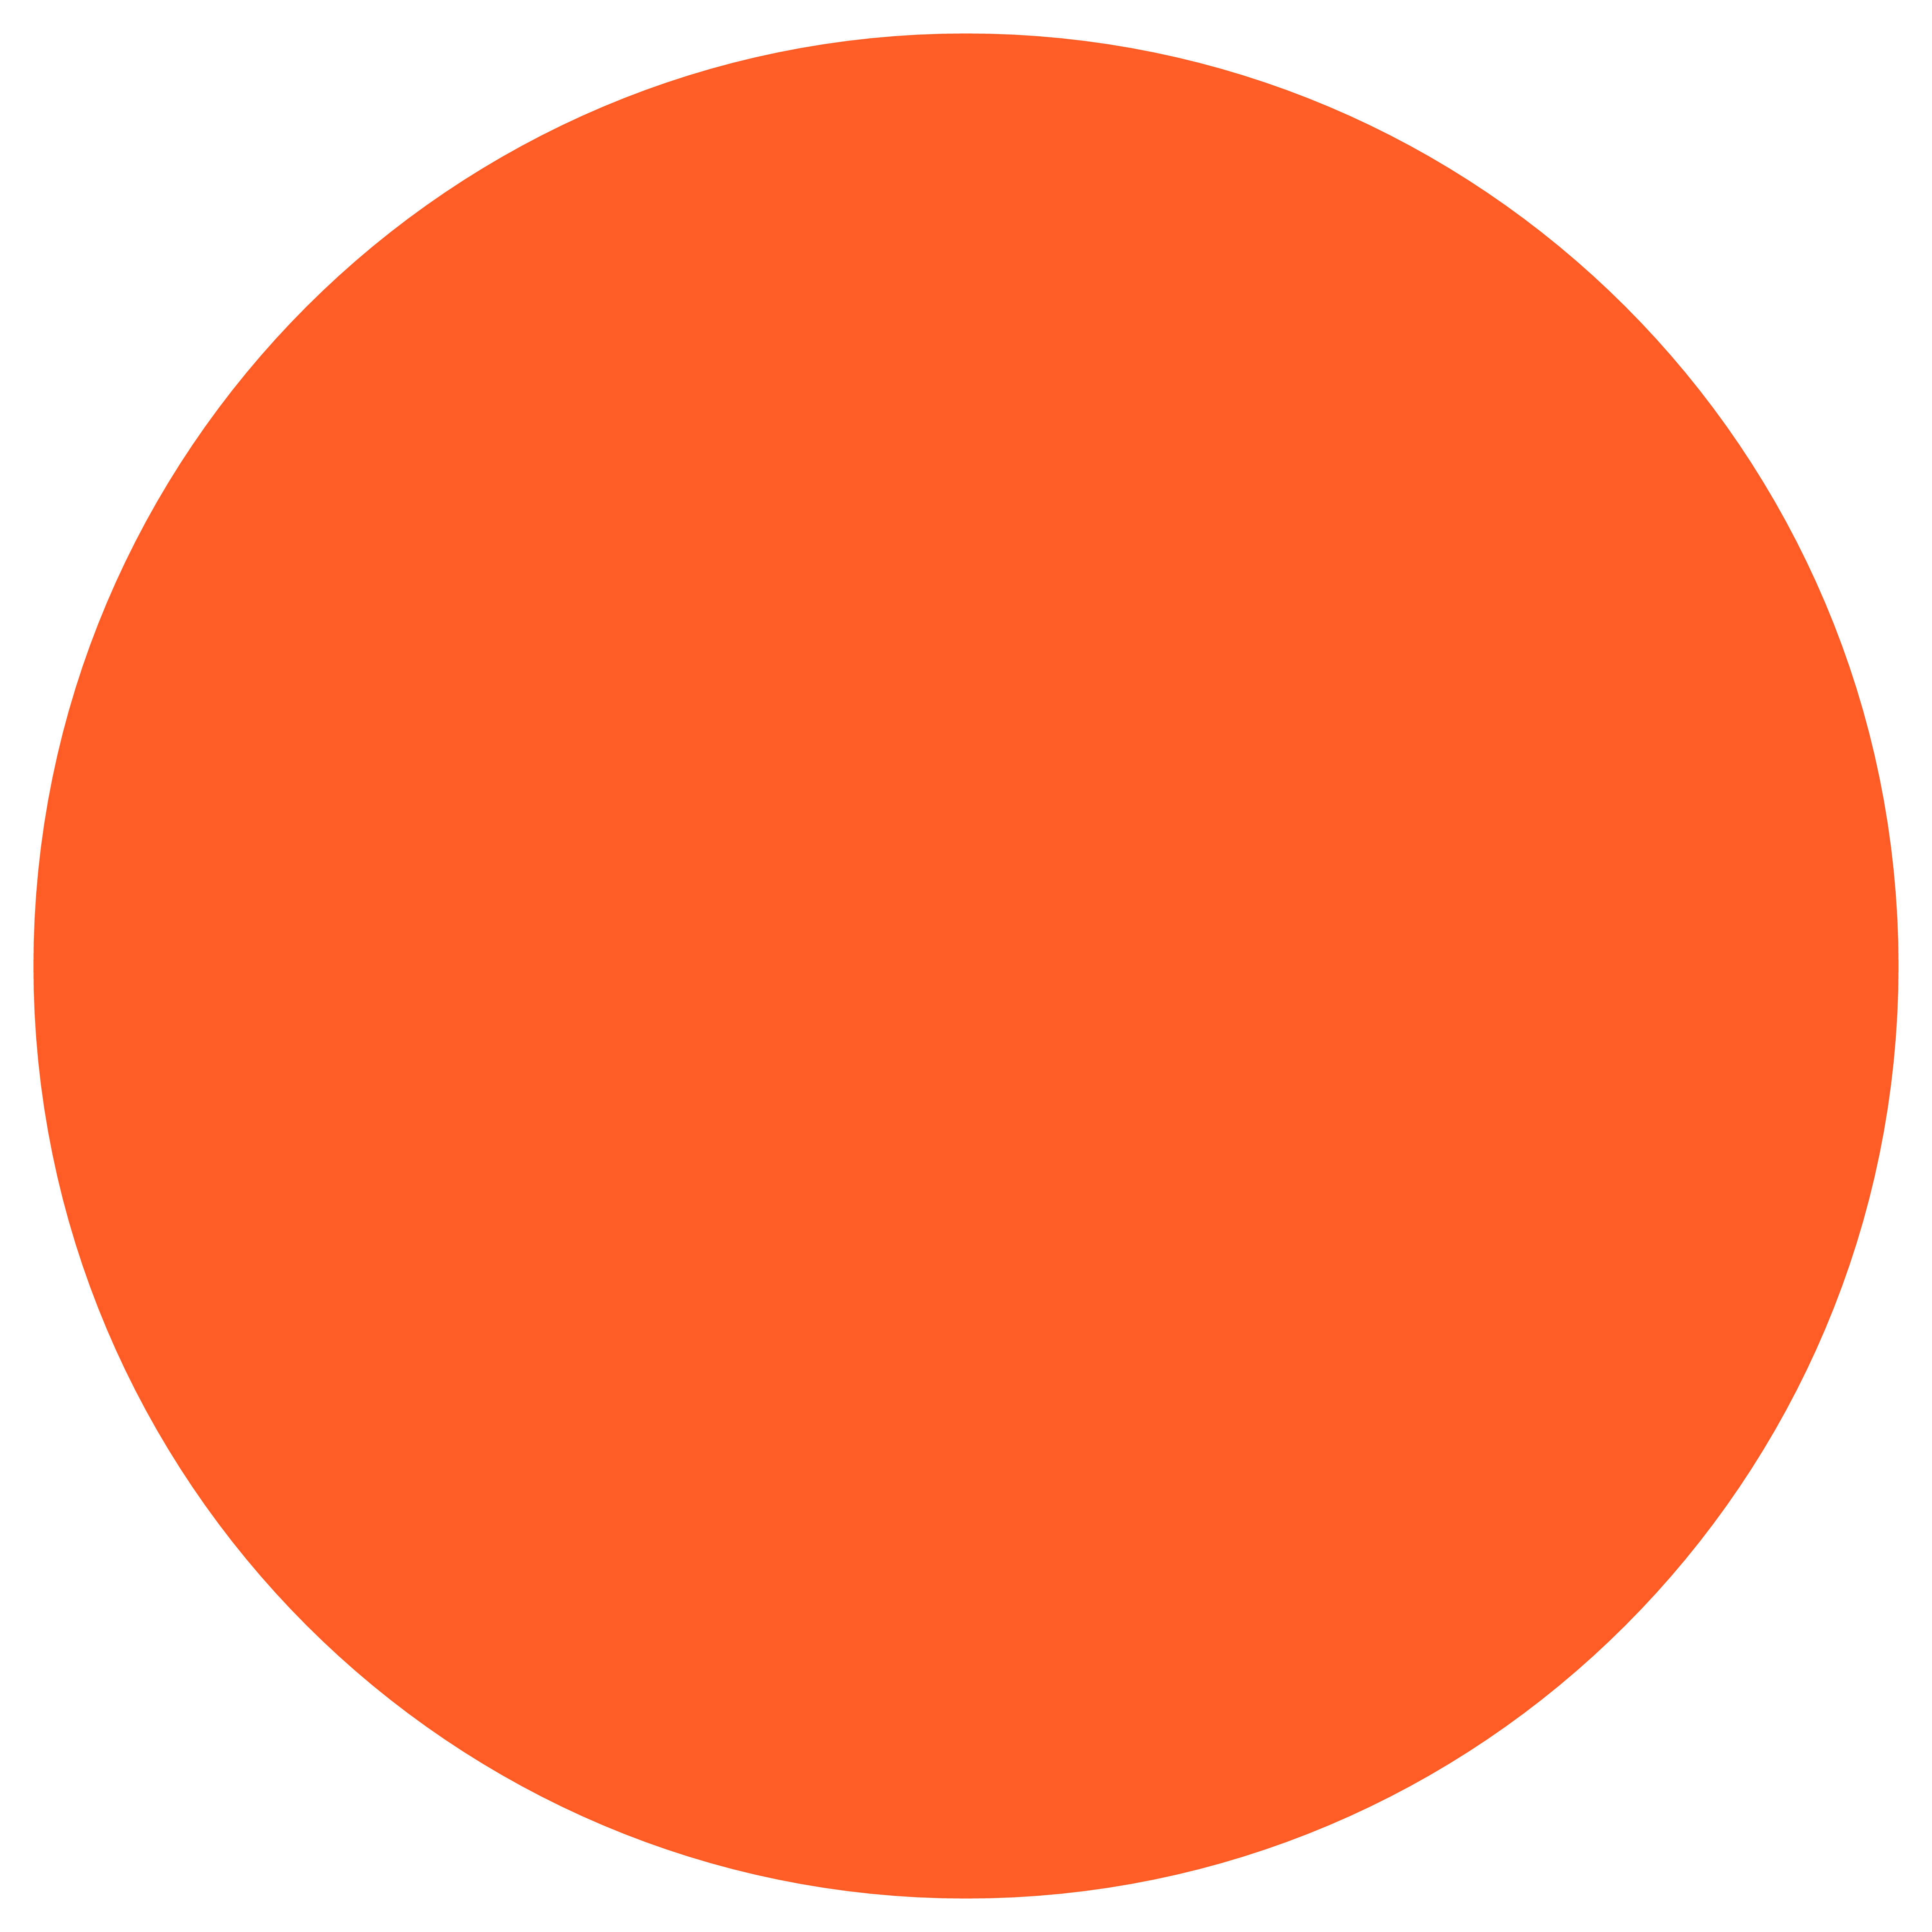

In [41]:
test_image_path = "/content/drive/My Drive/Shapes/circle.png"
predict_image(test_image_path)


image 1/1 /content/drive/My Drive/Shapes/rhombus.jpg: 448x640 1 rhombus, 28.1ms
Speed: 2.0ms preprocess, 28.1ms inference, 1.5ms postprocess per image at shape (1, 3, 448, 640)
Detected: rhombus | Confidence: 97.59%


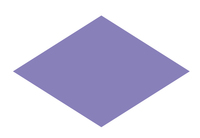

In [42]:
test_image_path = "/content/drive/My Drive/Shapes/rhombus.jpg"
predict_image(test_image_path)


image 1/1 /content/drive/My Drive/Shapes/square.png: 640x640 1 square, 37.1ms
Speed: 3.4ms preprocess, 37.1ms inference, 1.6ms postprocess per image at shape (1, 3, 640, 640)
Detected: square | Confidence: 97.81%


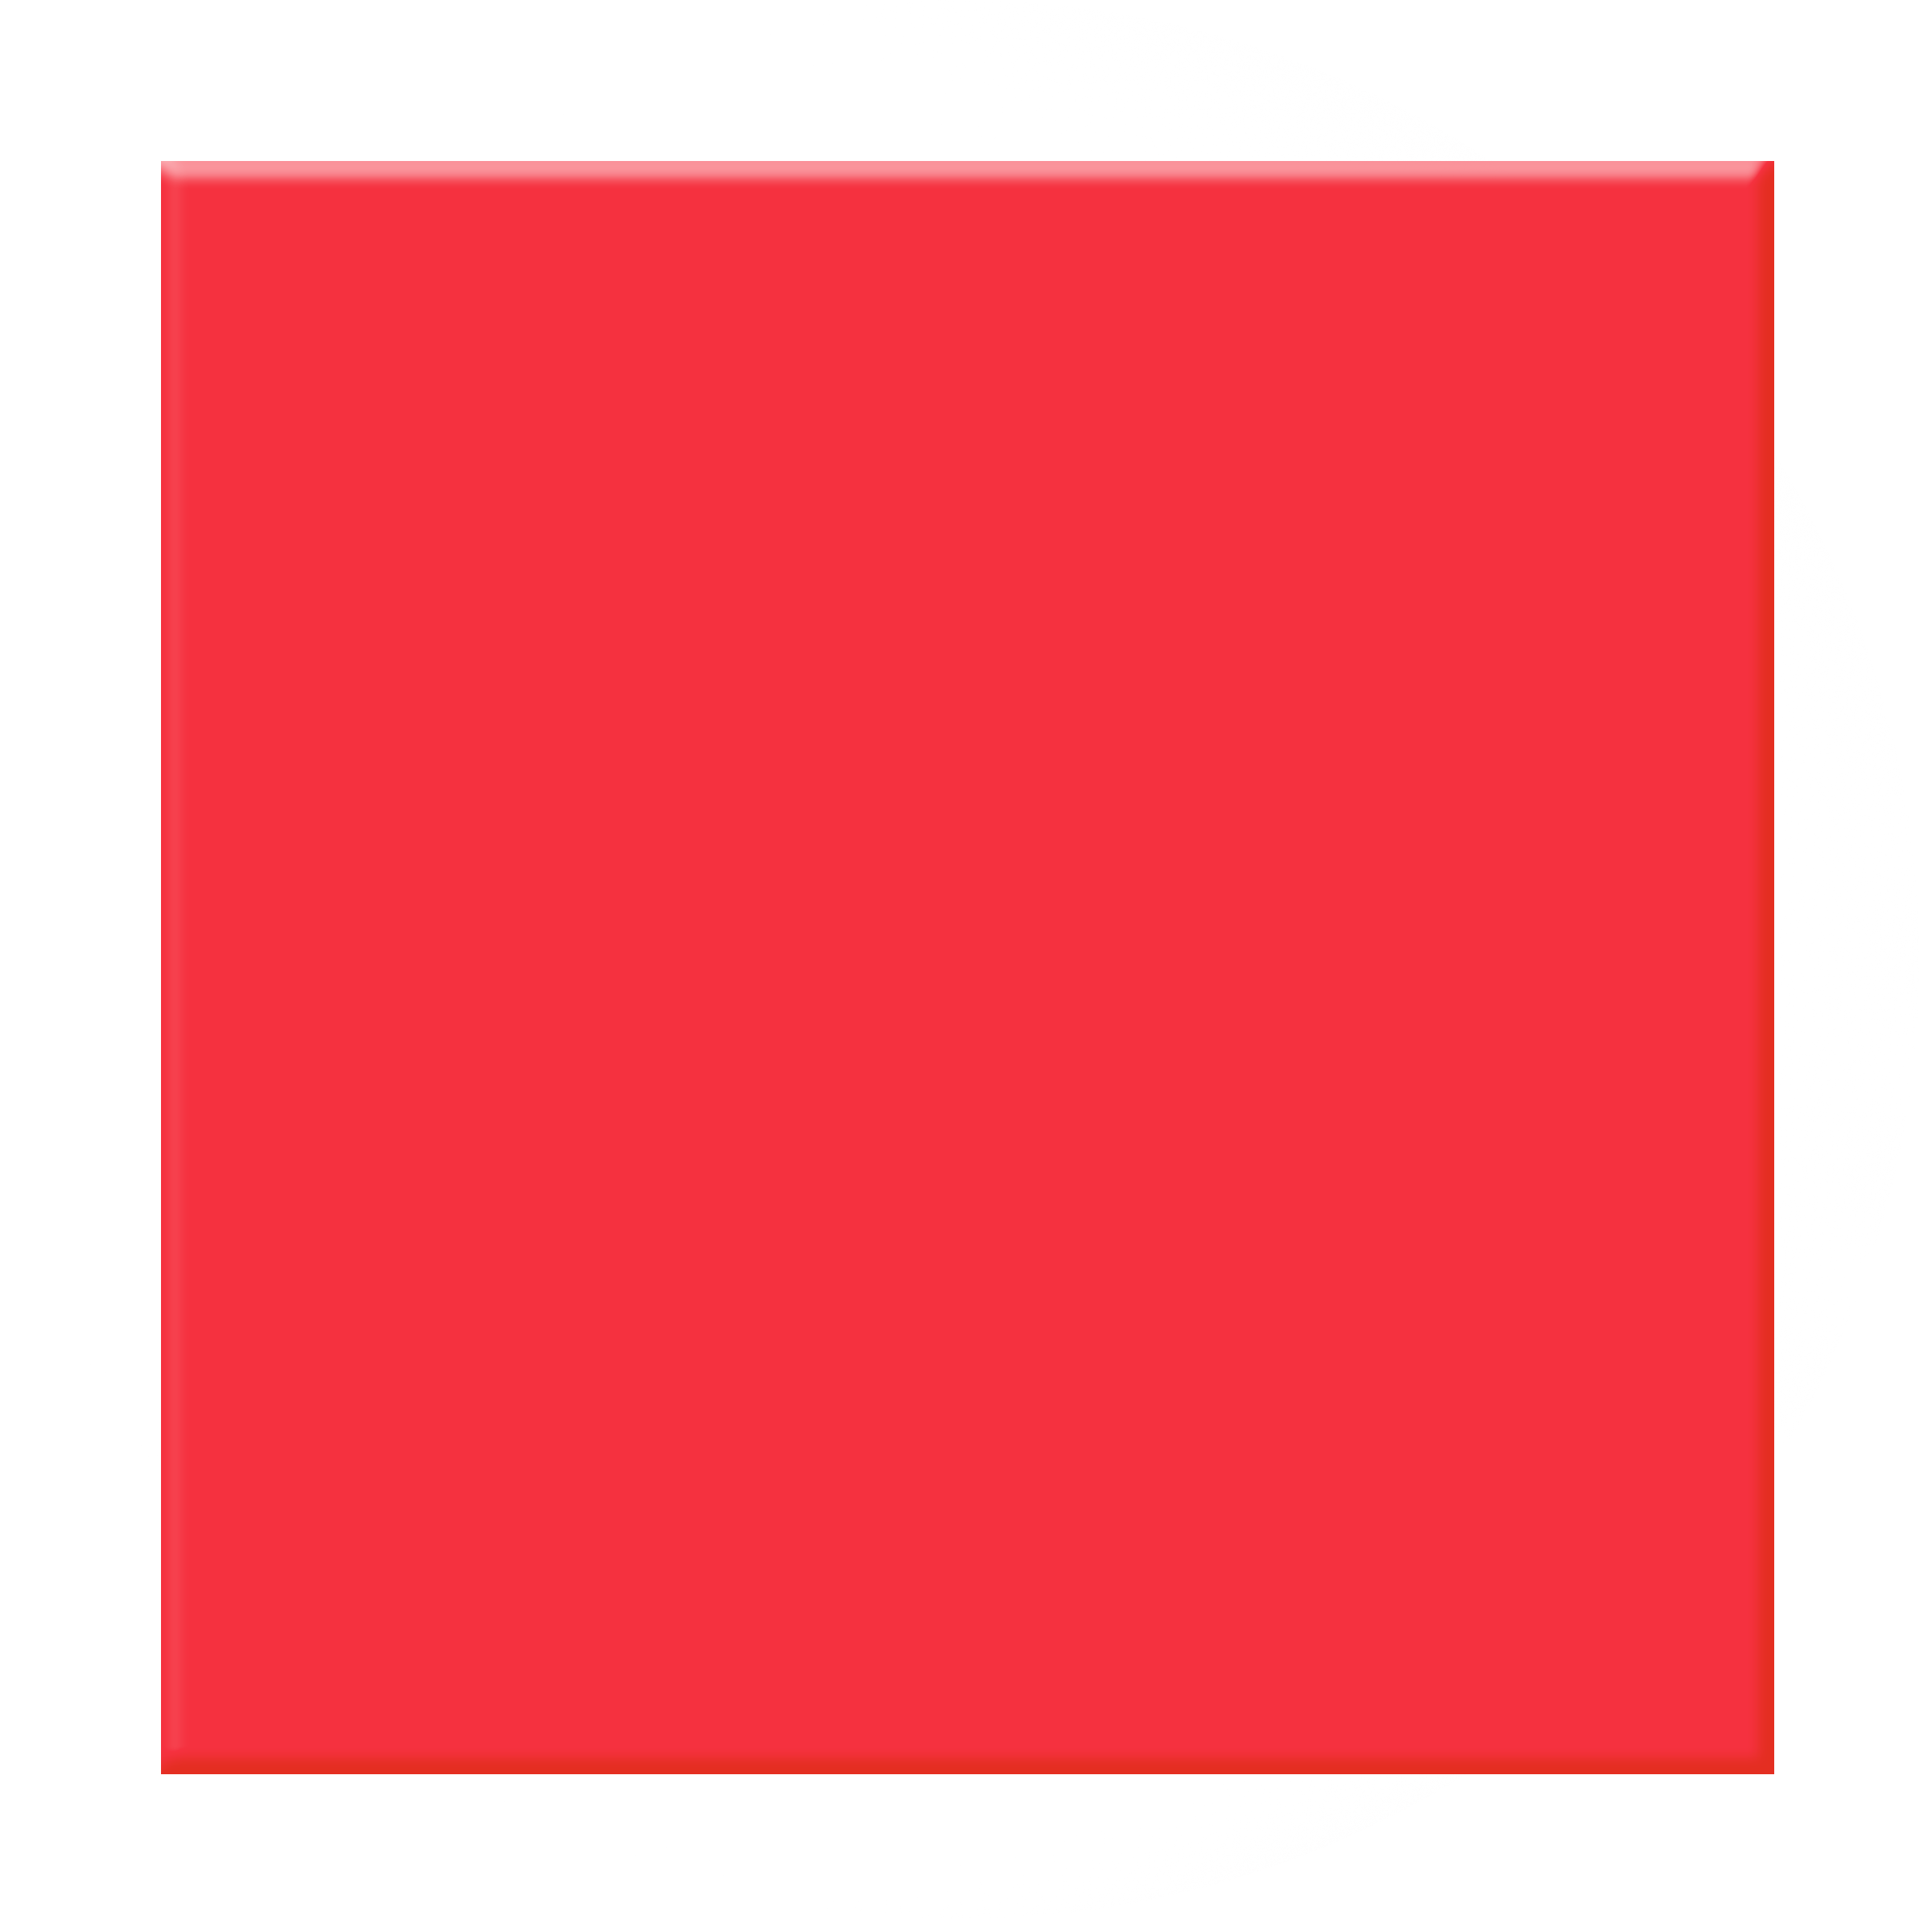

In [43]:
test_image_path = "/content/drive/My Drive/Shapes/square.png"
predict_image(test_image_path)

In [44]:
save_path = "/content/drive/MyDrive/yolo_models"

import os
if not os.path.exists(save_path):
    os.makedirs(save_path)

!cp runs/detect/train/weights/best.pt {save_path}/yolov8_shapes_detection_model_v1.pt